In [69]:
import operator
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200

import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl 

from clickhouse_driver import Client

client = Client('localhost', database="thesisattackimpactdb")

In [2]:
%%time 

exp_data_sql = """
SELECT
	ex.*
FROM
	experiment ex
"""
exp_df = client.query_dataframe(exp_data_sql)

exp_df["attacker_rate"] = exp_df["attacker_rate"].str.replace("mbps", "").astype(int)
exp_df["attacker_rate_mbps"] = exp_df["attacker_rate"]

print(len(exp_df.exp_id.unique().tolist()))
print("\n".join(exp_df.exp_id.unique().tolist()))
print()
exp_df

18
thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_attack_rate_impact_100mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_attack_rate_impact_10mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_attack_rate_impact_10mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_attack_rate_impact_1mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_attack_rate_impact_1mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_attack_rate_impact_2mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_attack_rate_impact_2mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_attack_rate_impact_3mbps_8clients_withattacker_coa

exp_id  \
0   thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1   thesis_group_attack_rate_impact_100mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_attack_rate_impact_10mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_attack_rate_impact_10mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
4     thesis_group_attack_rate_impact_1mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
5     thesis_group_attack_rate_impact_1mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
6     thesis_group_attack_rate_impact_2mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
7     thesis_group_attack_rate_impact_2mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
8     thesis_group_attack_rate_impact_3mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
9     thesis_group_attack_rate_impact_3mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
10    thesis_group_attack_rate_impact_4mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
11    thesis_group_attack_rate_impact_4mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
12   thesis_group_attack_rate_impact_50mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
13   thesis_group_attack_rate_impact_50mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
14    thesis_group_attack_rate_impact_5mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
15    thesis_group_attack_rate_impact_5mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
16                   thesis_group_num_clients_coap_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
17                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

    attacker_rate  server_connections  max_keep_alive_requests  num_clients  \
0             100                 256                        0            8   
1             100                 256                        0            8   
2              10                 256                        0            8   
3              10                 256                        0            8   
4               1                 256                        0            8   
5               1                 256                        0            8   
6               2                 256                        0            8   
7               2                 256                        0            8   
8               3                 256                        0            8   
9               3                 256                        0            8   
10              4                 256                        0            8   
11              4                 256                        0            8   
12             50                 256                        0            8   
13             50                 256                        0            8   
14              5                 256                        0            8   
15              5                 256                        0            8   
16              0                 256                        0            8   
17              0                 256                        0            8   

    num_trials  origin_server_duration  attacker_duration  receiver_duration  \
0            5                     140                 30                140   
1            5                     140                 30                140 

In [63]:
%%time 

fetch_metadata_sql = """
SELECT
	n.node_name,
	dn.dnid,
	dn.node_id,
  dn.exp_id
FROM 
	deployed_node dn
	JOIN node n ON n.node_id = dn.node_id
"""

metadata_df = client.query_dataframe(fetch_metadata_sql)

dnid_map_node_name = dict()
dnid_map_exp_id = dict()
node_id_map_node_name = dict()

for record in metadata_df.to_dict(orient="records"):
  dnid = record["dnid"]
  node_id = record["node_id"]
  node_name = record["node_name"]
  exp_id = record["exp_id"]
  
  assert dnid not in dnid_map_node_name
  dnid_map_node_name[dnid] = node_name
  dnid_map_exp_id[dnid] = exp_id
  
  if node_id in node_id_map_node_name:
    assert node_id_map_node_name[node_id] == node_name
  else:
    node_id_map_node_name[node_id] = node_name
  
client_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("client"))
attacker_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("attacker"))
proxy_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("proxy"))

client_node_ids = set(node_id for node_id, node_name in node_id_map_node_name.items() if node_name.startswith("client"))
attacker_node_ids = set(node_id for node_id, node_name in node_id_map_node_name.items() if node_name.startswith("attacker"))
print(f"{client_dnids=}")
print(f"{attacker_dnids=}")
print(f"{client_node_ids=}")

client_dnids={2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21, 26, 27, 28, 29, 30, 31, 32, 33, 38, 39, 40, 41, 42, 43, 44, 45, 50, 51, 52, 53, 54, 55, 56, 57, 62, 63, 64, 65, 66, 67, 68, 69, 74, 75, 76, 77, 78, 79, 80, 81, 86, 87, 88, 89, 90, 91, 92, 93, 98, 99, 100, 101, 102, 103, 104, 105, 110, 111, 112, 113, 114, 115, 116, 117, 122, 123, 124, 125, 126, 127, 128, 129, 134, 135, 136, 137, 138, 139, 140, 141, 146, 147, 148, 149, 150, 151, 152, 153, 158, 159, 160, 161, 162, 163, 164, 165, 170, 171, 172, 173, 174, 175, 176, 177, 182, 183, 184, 185, 186, 187, 188, 189, 194, 195, 196, 197, 198, 199, 200, 201, 206, 207, 208, 209, 210, 211, 212, 213}
attacker_dnids={1, 97, 121, 193, 37, 133, 73, 169, 13, 109, 205, 49, 145, 85, 157, 181, 25, 61}
client_node_ids={2, 3, 4, 5, 6, 7, 8, 9}
CPU times: user 29.6 ms, sys: 3.8 ms, total: 33.4 ms
Wall time: 53.6 ms


In [4]:
%%time

client_messages_sql = f"""
WITH client_sends AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
), 

client_recvs AS (
  SELECT
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_code AS response_code
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT
  client_sends.exp_id AS exp_id,
  client_sends.trial AS trial,
  client_sends.observer_id AS observer_id,
  client_sends.message_marker AS message_marker,
  groupArray(client_recvs.response_code)[1] AS response_code,
  MIN(client_sends.observe_timestamp) AS send_time_sec,
  MIN(client_recvs.observe_timestamp) AS recv_time_sec,
  MIN(client_sends.observe_timestamp) AS first_send_time_sec,
  MAX(client_sends.observe_timestamp) AS last_send_time_sec,
  MIN(client_recvs.observe_timestamp) AS first_recv_time_sec,
  MAX(client_recvs.observe_timestamp) AS last_recv_time_sec,
  1e3 * (MIN(client_recvs.observe_timestamp) - MIN(client_sends.observe_timestamp)) AS rtt_ms_first_transmission,
  1e3 * (MIN(client_recvs.observe_timestamp) - MAX(client_sends.observe_timestamp)) AS rtt_ms_last_transmission,
  COUNT(client_sends.observe_timestamp) AS num_send_observations,
  COUNT(client_recvs.observe_timestamp) AS num_recv_observations,
  SUM(CASE WHEN client_sends.coap_retransmitted = true THEN 1 ELSE 0 END) AS num_retransmissions
FROM client_sends
  LEFT JOIN client_recvs USING (trial, observer_id, message_marker)
GROUP BY 
  exp_id, trial, observer_id, message_marker
ORDER BY
  exp_id, trial, observer_id, message_marker
"""

message_rtt_df = client.query_dataframe(client_messages_sql)
message_rtt_df.observer_id.replace(dnid_map_node_name, inplace=True)

message_rtt_df["successful_message"] = False
message_rtt_df.loc[(message_rtt_df["response_code"] == "content"), "successful_message"] = True

print(message_rtt_df["response_code"].unique())

message_rtt_df = message_rtt_df.merge(exp_df, on="exp_id", how="left")

# Due to left join, we need to eliminate lines that
# have negative RTT, so we NaN them.
message_rtt_df.loc[
  (message_rtt_df["rtt_ms_first_transmission"] < 0)
  | (message_rtt_df["rtt_ms_last_transmission"] < 0)
  ,
  ["rtt_ms_first_transmission", "rtt_ms_last_transmission"]
] = np.nan

message_rtt_df

['content' 'bad_gateway' '']
CPU times: user 6.38 s, sys: 3.42 s, total: 9.8 s
Wall time: 14.2 s


exp_id  \
0        thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1        thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2        thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3        thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4        thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                        ...   
1360946                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1360947                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1360948                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1360949                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1360950                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

         trial observer_id  message_marker response_code  send_time_sec  \
0            1     client1               1       content       0.000000   
1            1     client1               2       content       0.364401   
2            1     client1               3       content       0.426992   
3            1     client1               4       content       0.489618   
4            1     client1               5       content       0.550316   
...        ...         ...             ...           ...            ...   
1360946      5     client8           17773       content     125.717236   
1360947      5     client8           17774       content     125.770620   
1360948      5     client8           17775       content     125.823910   
1360949      5     client8           17776       content     125.877252   
1360950      5     client8           17777                   125.930663   

         recv_time_sec  first_send_time_sec  last_send_time_sec  \
0             0.348999             0.000000            0.000000   
1             0.424893             0.364401            0.364401   
2             0.487365             0.426992            0.426992   
3             0.547904             0.489618            0.489618   
4             0.607015             0.550316            0.550316   
...                ...                  ...                 ...   
1360946     125.769829           125.717236          125.717236   
1360947     125.823153           125.770620          125.770620   
1360948     125.876400           125.823910          125.823910   
1360949     125.929843           125.877252          125.877252   
1360950       0.000000           125.930663          125.930663   

         first_recv_time_sec  ...  num_proxy_connections  request_timeout  \
0                   0.348999  ...                     50                5   
1                   0.424893  ...                     50                5   
2                   0.487365  ...                     50                5   
3                   0.547904  ...                     50                5   
4                   0.607015  ...                     50                5   
...                      ...  ...                    ...              ...   
1360946           125.769829  ...                     50                5   
1360947           125.823153  ...                     50                5   
1360948           125.876400  ...                     50                5   
1360949           125.929843  ...                     50                5   
136095

In [5]:
%%time

metric_usage_sql = f"""
SELECT
	dn.exp_id,
	nm.trial,
	nm.observer_id,
	nm.metric_type,
	AVG(nm.metric_value) AS avg_value,
	MIN(nm.metric_value) AS min_value,
	MAX(nm.metric_value) AS max_value
FROM
	node_metric nm
	JOIN deployed_node dn ON dn.dnid = nm.observer_id
GROUP BY
	dn.exp_id, nm.trial, nm.observer_id, nm.metric_type
ORDER BY
	dn.exp_id, nm.trial, nm.metric_type, nm.observer_id
"""

metric_df = client.query_dataframe(metric_usage_sql)

metric_df.observer_id.replace(dnid_map_node_name, inplace=True)

metric_df = metric_df.merge(exp_df, on="exp_id", how="left")

metric_df

CPU times: user 33.1 ms, sys: 1.62 ms, total: 34.7 ms
Wall time: 120 ms


exp_id  \
0    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                     ...   
355                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
356                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
357                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
358                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
359                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

     trial   observer_id         metric_type    avg_value  min_value  \
0        1  originserver     cpu_utilization     4.782857        0.5   
1        1         proxy     cpu_utilization    15.685000        0.4   
2        1  originserver  memory_utilization   291.244628      268.0   
3        1         proxy  memory_utilization  3499.525000      256.0   
4        2  originserver     cpu_utilization     4.847857        0.4   
..     ...           ...                 ...          ...        ...   
355      4         proxy  memory_utilization   462.127273      245.0   
356      5  originserver     cpu_utilization     1.485714        0.4   
357      5         proxy     cpu_utilization     3.462143        0.5   
358      5  originserver  memory_utilization   260.966997      247.0   
359      5         proxy  memory_utilization   466.800000      244.0   

     max_value  attacker_rate  server_connections  max_keep_alive_requests  \
0         22.4            100                 256                        0   
1         86.6            100                 256                        0   
2        308.0            100                 256                        0   
3       5746.0            100                 256                        0   
4         21.4            100                 256                        0   
..         ...            ...                 ...                      ...   
355      495.0              0                 256                        0   
356        9.2              0                 256                        0   
357       26.5              0                 256                        0   
358      262.0              0                 256                        0   
359      503.0              0                 256                        0   

     ...  num_proxy_connections  request_timeout  max_retries  \
0    ...                     50                5            2   
1    ...                     50                5            2   
2    ...                     50                5            2   
3    ...                     50                5            2   
4    ...                     50                5            2   
..   ...                    ...              ...          ...   
355  ...                     50                5            2   
356  ...                     50                5            2   
357  ...                     50                5            2   
358  ...                     50                5            2   
359  ...                     50                5            2   

     keep_alive_dura

In [6]:
%%time

client_rps_df = (
  message_rtt_df
  .groupby(by=["exp_id", "trial", "observer_id"])
  .aggregate(
    num_messages=("successful_message", "count"),
    num_successful_messages=("successful_message", "sum"),
    mean_rps=("successful_message", "sum"),
    max_num_retransmissions=("num_retransmissions", "max"),
    total_num_retransmissions=("num_retransmissions", "sum"),
    stddev_rtt_ms=("rtt_ms_first_transmission", "std"),
    min_rtt_ms=("rtt_ms_first_transmission", "min"),
    median_rtt_ms=("rtt_ms_first_transmission", "median"),
    mean_rtt_ms=("rtt_ms_first_transmission", "mean"),
    max_rtt_ms=("rtt_ms_first_transmission", "max"),
    rtt_ms_p0=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.00)),
    rtt_ms_p25=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.25)),
    rtt_ms_p50=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.50)),
    rtt_ms_p75=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.75)),
    rtt_ms_p90=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.90)),
    rtt_ms_p99=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.99)),
    rtt_ms_p100=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=1.00)),
    first_active_time=("first_send_time_sec", "min"),
    last_active_time=("last_recv_time_sec", "max"),
  )
  .reset_index()
)
# assert client_rps_df["min_rtt_ms"].eq(client_rps_df["rtt_ms_p0"]).all()
# assert client_rps_df["median_rtt_ms"].eq(client_rps_df["rtt_ms_p50"]).all()
# assert client_rps_df["max_rtt_ms"].eq(client_rps_df["rtt_ms_p100"]).all()

client_rps_df["num_failed_messages"] = client_rps_df["num_messages"] - client_rps_df["num_successful_messages"]
client_rps_df["average_rps"] = client_rps_df["num_successful_messages"] / (client_rps_df["last_active_time"] - client_rps_df["first_active_time"])

client_rps_df = client_rps_df.merge(exp_df, on="exp_id")
bool_col_replacement = {
  "run_proxy_with_dtls": {True: "dtls", False: "coap"},
  "run_proxy_with_https": {True: "https", False: "http"},
  "reuse_connections": {True: "reuse-connections", False: "no-connection-reuse"},
  "run_attacker": {True: "attacker", False: "no-attacker"},
}
client_rps_df.replace(bool_col_replacement, inplace=True)

client_rps_df["mean_rps"] /= client_rps_df["client_duration"]

client_rps_df[["exp_id", "trial", "observer_id", "mean_rps"]]

client_rps_df

CPU times: user 4.93 s, sys: 1.66 ms, total: 4.93 s
Wall time: 4.93 s


exp_id  \
0    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                     ...   
715                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
716                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
717                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
718                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
719                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

     trial observer_id  num_messages  num_successful_messages   mean_rps  \
0        1     client1          1568                     1563  13.025000   
1        1     client2          1577                     1570  13.083333   
2        1     client3          1578                     1573  13.108333   
3        1     client4          1577                     1573  13.108333   
4        1     client5          1580                     1573  13.108333   
..     ...         ...           ...                      ...        ...   
715      5     client4          2211                     2210  18.416667   
716      5     client5          2219                     2218  18.483333   
717      5     client6          2219                     2218  18.483333   
718      5     client7          2220                     2220  18.500000   
719      5     client8          2220                     2219  18.491667   

     max_num_retransmissions  total_num_retransmissions  stddev_rtt_ms  \
0                          2                          8     357.855134   
1                          1                          7     320.695932   
2                          1                          6     359.381135   
3                          2                          7     383.431770   
4                          1                          7     320.290151   
..                       ...                        ...            ...   
715                        0                          0       1.313610   
716                        0                          0       0.544515   
717                        0                          0       0.817425   
718                        0                          0       0.749001   
719                        0                          0       0.750335   

     min_rtt_ms  ...  num_proxy_connections  request_timeout  max_retries  \
0     51.851988  ...                     50                5            2   
1     51.739931  ...                     50                5            2   
2     51.803112  ...                     50                5            2   
3     51.846027  ...                     50                5            2   
4     51.772118  ...                     50                5            2   
..          ...  ...                    ...              ...          ...   
715   51.450014  ...                     50                5            2   
716   51.644802  ...                     50                5            2   
717   51.687956  ...                     50                5            2   
718   51.648855  ...           

In [7]:
%%time

communication_pattern_rates_sql = f"""
WITH all_patterns AS (
  SELECT
    dn.exp_id AS exp_id,
    e.trial AS trial,
    e.observe_timestamp AS observe_timestamp,
    floor(e.observe_timestamp) AS timestamp_bin,
    e.message_marker AS message_marker,
    concat(node_src.node_name, '->', node_dst.node_name) AS communication_pattern,
    m.size_bytes AS size_bytes
  FROM
    event e
    JOIN deployed_node dn ON dn.dnid = e.observer_id
    JOIN message m ON m.message_id = e.message_id
    JOIN node node_src ON node_src.node_id = m.src_id
    JOIN node node_dst ON node_dst.node_id = m.dst_id

), pattern_aggregations AS (
  SELECT
    exp_id,
    trial,
    communication_pattern,
    timestamp_bin,
    SUM(size_bytes) AS sum_bytes,
    COUNT(DISTINCT message_marker) AS num_messages
  FROM
    all_patterns
  GROUP BY
    exp_id, trial, communication_pattern, timestamp_bin
)

SELECT
  *,
  (1e-6 * sum_bytes) AS megabytes_per_second,
  (8 * 1e-6 * sum_bytes) AS megabits_per_second
FROM
  pattern_aggregations
ORDER BY
  timestamp_bin
"""

binned_messages_df = client.query_dataframe(communication_pattern_rates_sql)

binned_messages_df = binned_messages_df.merge(exp_df, on="exp_id", how="left")

binned_messages_df

CPU times: user 606 ms, sys: 71.2 ms, total: 677 ms
Wall time: 34.6 s


exp_id  \
0       thesis_group_attack_rate_impact_10mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1       thesis_group_attack_rate_impact_10mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2        thesis_group_attack_rate_impact_5mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3        thesis_group_attack_rate_impact_1mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
4        thesis_group_attack_rate_impact_4mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                      ...   
186768   thesis_group_attack_rate_impact_1mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
186769   thesis_group_attack_rate_impact_5mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
186770   thesis_group_attack_rate_impact_1mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
186771   thesis_group_attack_rate_impact_4mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
186772   thesis_group_attack_rate_impact_4mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   

        trial communication_pattern  timestamp_bin  sum_bytes  num_messages  \
0           2   originserver->proxy            0.0       6383            13   
1           4        proxy->client7            0.0       1755             9   
2           4        proxy->client7            0.0       1755             9   
3           4        client1->proxy            0.0       3752            13   
4           3   proxy->originserver            0.0       2763            12   
...       ...                   ...            ...        ...           ...   
186768      4   proxy->originserver          126.0       1398             6   
186769      2        client8->proxy          126.0       1176             7   
186770      4   proxy->originserver          126.0       3029            13   
186771      4        proxy->client8          126.0       2964            10   
186772      4        proxy->client8          126.0       4343            14   

        megabytes_per_second  megabits_per_second  attacker_rate  \
0                   0.006383             0.051064             10   
1                   0.001755             0.014040             10   
2                   0.001755             0.014040              5   
3                   0.003752             0.030016              1   
4                   0.002763             0.022104              4   
...                      ...                  ...            ...   
186768              0.001398             0.011184              1   
186769              0.001176             0.009408              5   
186770              0.003029             0.024232              1   
186771              0.002964             0.023712              4   
186772              0.004343             0.034744              4   

        server_connections  ...  num_proxy_connections  request_timeout  \
0                      256  ...                     50                5   
1                      256  ...                     50                5   
2                      256  ...                     50                5   
3                      256  ...                     50                5   
4                      256  ...                     50                5   
...                    ...  ...                    ...              ...   
186768                 256  ...                     50                5   
186769                 256  ...                     50                5   
186770                 256  ...                     50                5   
186771                 256  ...                     50           

In [8]:
# %%time

# # Example:
# # thesis_group_attack_rate_impact_10mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client
# # Becomes:
# # 10mbps_CoAPS

# filtered_binned_messages_df = binned_messages_df.copy()
# filtered_binned_messages_df["exp_id"] = filtered_binned_messages_df["exp_id"].str.replace("thesis_group_attack_rate_impact_", "")
# filtered_binned_messages_df["exp_id"] = filtered_binned_messages_df["exp_id"].str.replace("8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client", "CoAPS")
# filtered_binned_messages_df["exp_id"] = filtered_binned_messages_df["exp_id"].str.replace("8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client", "CoAP")

filtered_binned_messages_df = binned_messages_df[
  (binned_messages_df["communication_pattern"].str.contains("attacker->proxy"))
]

filtered_binned_messages_df

exp_id  \
41338    thesis_group_attack_rate_impact_3mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
42833    thesis_group_attack_rate_impact_3mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
44086    thesis_group_attack_rate_impact_3mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
46054    thesis_group_attack_rate_impact_3mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
47224    thesis_group_attack_rate_impact_3mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                      ...   
98615  thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
98681    thesis_group_attack_rate_impact_4mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
98689    thesis_group_attack_rate_impact_4mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
98705    thesis_group_attack_rate_impact_1mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
98713    thesis_group_attack_rate_impact_1mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

       trial communication_pattern  timestamp_bin  sum_bytes  num_messages  \
41338      3       attacker->proxy           27.0     583708          2010   
42833      3       attacker->proxy           28.0     750002          2590   
44086      3       attacker->proxy           29.0     668826          2568   
46054      3       attacker->proxy           30.0     604732          2840   
47224      3       attacker->proxy           31.0     749856          2590   
...      ...                   ...            ...        ...           ...   
98615      4       attacker->proxy           67.0    2911464         13489   
98681      5       attacker->proxy           67.0     336238          1224   
98689      5       attacker->proxy           67.0     566136          2683   
98705      5       attacker->proxy           67.0      72011           346   
98713      5       attacker->proxy           67.0      92856           330   

       megabytes_per_second  megabits_per_second  attacker_rate  \
41338              0.583708             4.669664              3   
42833              0.750002             6.000016              3   
44086              0.668826             5.350608              3   
46054              0.604732             4.837856              3   
47224              0.749856             5.998848              3   
...                     ...                  ...            ...   
98615              2.911464            23.291712            100   
98681              0.336238             2.689904              4   
98689              0.566136             4.529088              4   
98705              0.072011             0.576088              1   
98713              0.092856             0.742848              1   

       server_connections  ...  num_proxy_connections  request_timeout  \
41338                 256  ...                     50                5   
42833                 256  ...                     50                5   
44086                 256  ...                     50                5   
46054                 256  ...                     50                5   
47224                 256  ...                     50                5   
...                   ...  ...                    ...              ...   
98615                 256  ...                     50                5   
98681                 256  ...                     50                5   
98689                 256  ...                     50                5   
98705                 256  ...                     50                5   
98713                 256

In [31]:
melted_filtered_binned_messages_df = (
  filtered_binned_messages_df
  .melt(
    id_vars=["exp_id", "trial", "timestamp_bin"],
    value_vars=["num_messages", "megabits_per_second"],
    var_name="rate_metric",
    value_name="metric_value",
  )
)

melted_filtered_binned_messages_df = melted_filtered_binned_messages_df.merge(exp_df, on="exp_id", how="left")

melted_filtered_binned_messages_df

exp_id  \
0       thesis_group_attack_rate_impact_3mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1       thesis_group_attack_rate_impact_3mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
2       thesis_group_attack_rate_impact_3mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
3       thesis_group_attack_rate_impact_3mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
4       thesis_group_attack_rate_impact_3mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                     ...   
4947  thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4948    thesis_group_attack_rate_impact_4mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
4949    thesis_group_attack_rate_impact_4mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4950    thesis_group_attack_rate_impact_1mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4951    thesis_group_attack_rate_impact_1mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

      trial  timestamp_bin          rate_metric  metric_value  attacker_rate  \
0         3           27.0         num_messages   2010.000000              3   
1         3           28.0         num_messages   2590.000000              3   
2         3           29.0         num_messages   2568.000000              3   
3         3           30.0         num_messages   2840.000000              3   
4         3           31.0         num_messages   2590.000000              3   
...     ...            ...                  ...           ...            ...   
4947      4           67.0  megabits_per_second     23.291712            100   
4948      5           67.0  megabits_per_second      2.689904              4   
4949      5           67.0  megabits_per_second      4.529088              4   
4950      5           67.0  megabits_per_second      0.576088              1   
4951      5           67.0  megabits_per_second      0.742848              1   

      server_connections  max_keep_alive_requests  num_clients  num_trials  \
0                    256                        0            8           5   
1                    256                        0            8           5   
2                    256                        0            8           5   
3                    256                        0            8           5   
4                    256                        0            8           5   
...                  ...                      ...          ...         ...   
4947                 256                        0            8           5   
4948                 256                        0            8           5   
4949                 256                        0            8           5   
4950                 256                        0            8           5   
4951                 256                        0            8           5   

      ...  num_proxy_connections  request_timeout  max_retries  \
0     ...                     50                5            2   
1     ...                     50                5            2   
2     ...                     50                5            2   
3     ...                     50                5            2   
4     ...                     50                5            2   
...   ...                    ...              ...          ...   
4947  ...                     50                5            2   
4948  ...                     50                5            2   
4949  ...                     50                5            2   
4950  ...                     50  

In [32]:
### At this point, we generate figures for the paper

plt.rcParams['figure.dpi']  = 300
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['font.size']        = '18'
plt.rcParams['lines.linewidth']  = 3
plt.rcParams['lines.markersize'] = 9

value_map_replacement = {
  "run_proxy_with_dtls": {
    "coap": "CoAP",
    False: "CoAP",
    "dtls": "CoAPS",
    True: "CoAPS",
  },
  "reuse_connections": {
    "reuse-connections": "Reuse Connections",
    True: "Reuse Connections",
    "no-connection-reuse": "No Connection Reuse",
    False: "No Connection Reuse",
  },
  "topology_orientation": {
    "far_proxy_close_server": "Far Proxy & Close Server",
    "close_proxy_far_server": "Far Server & Close Proxy",
  },
  "run_attacker": {
    "attacker": "With Attacker",
    True: "With Attacker",
    "no-attacker": "Without Attacker",
    False: "Without Attacker",
  },
  "response_code": {
    "bad_gateway": "Bad Gateway",
    "content": "Content",
  },
}

client_rps_df.replace(value_map_replacement, inplace=True)
metric_df.replace(value_map_replacement, inplace=True)
melted_filtered_binned_messages_df.replace(value_map_replacement, inplace=True)

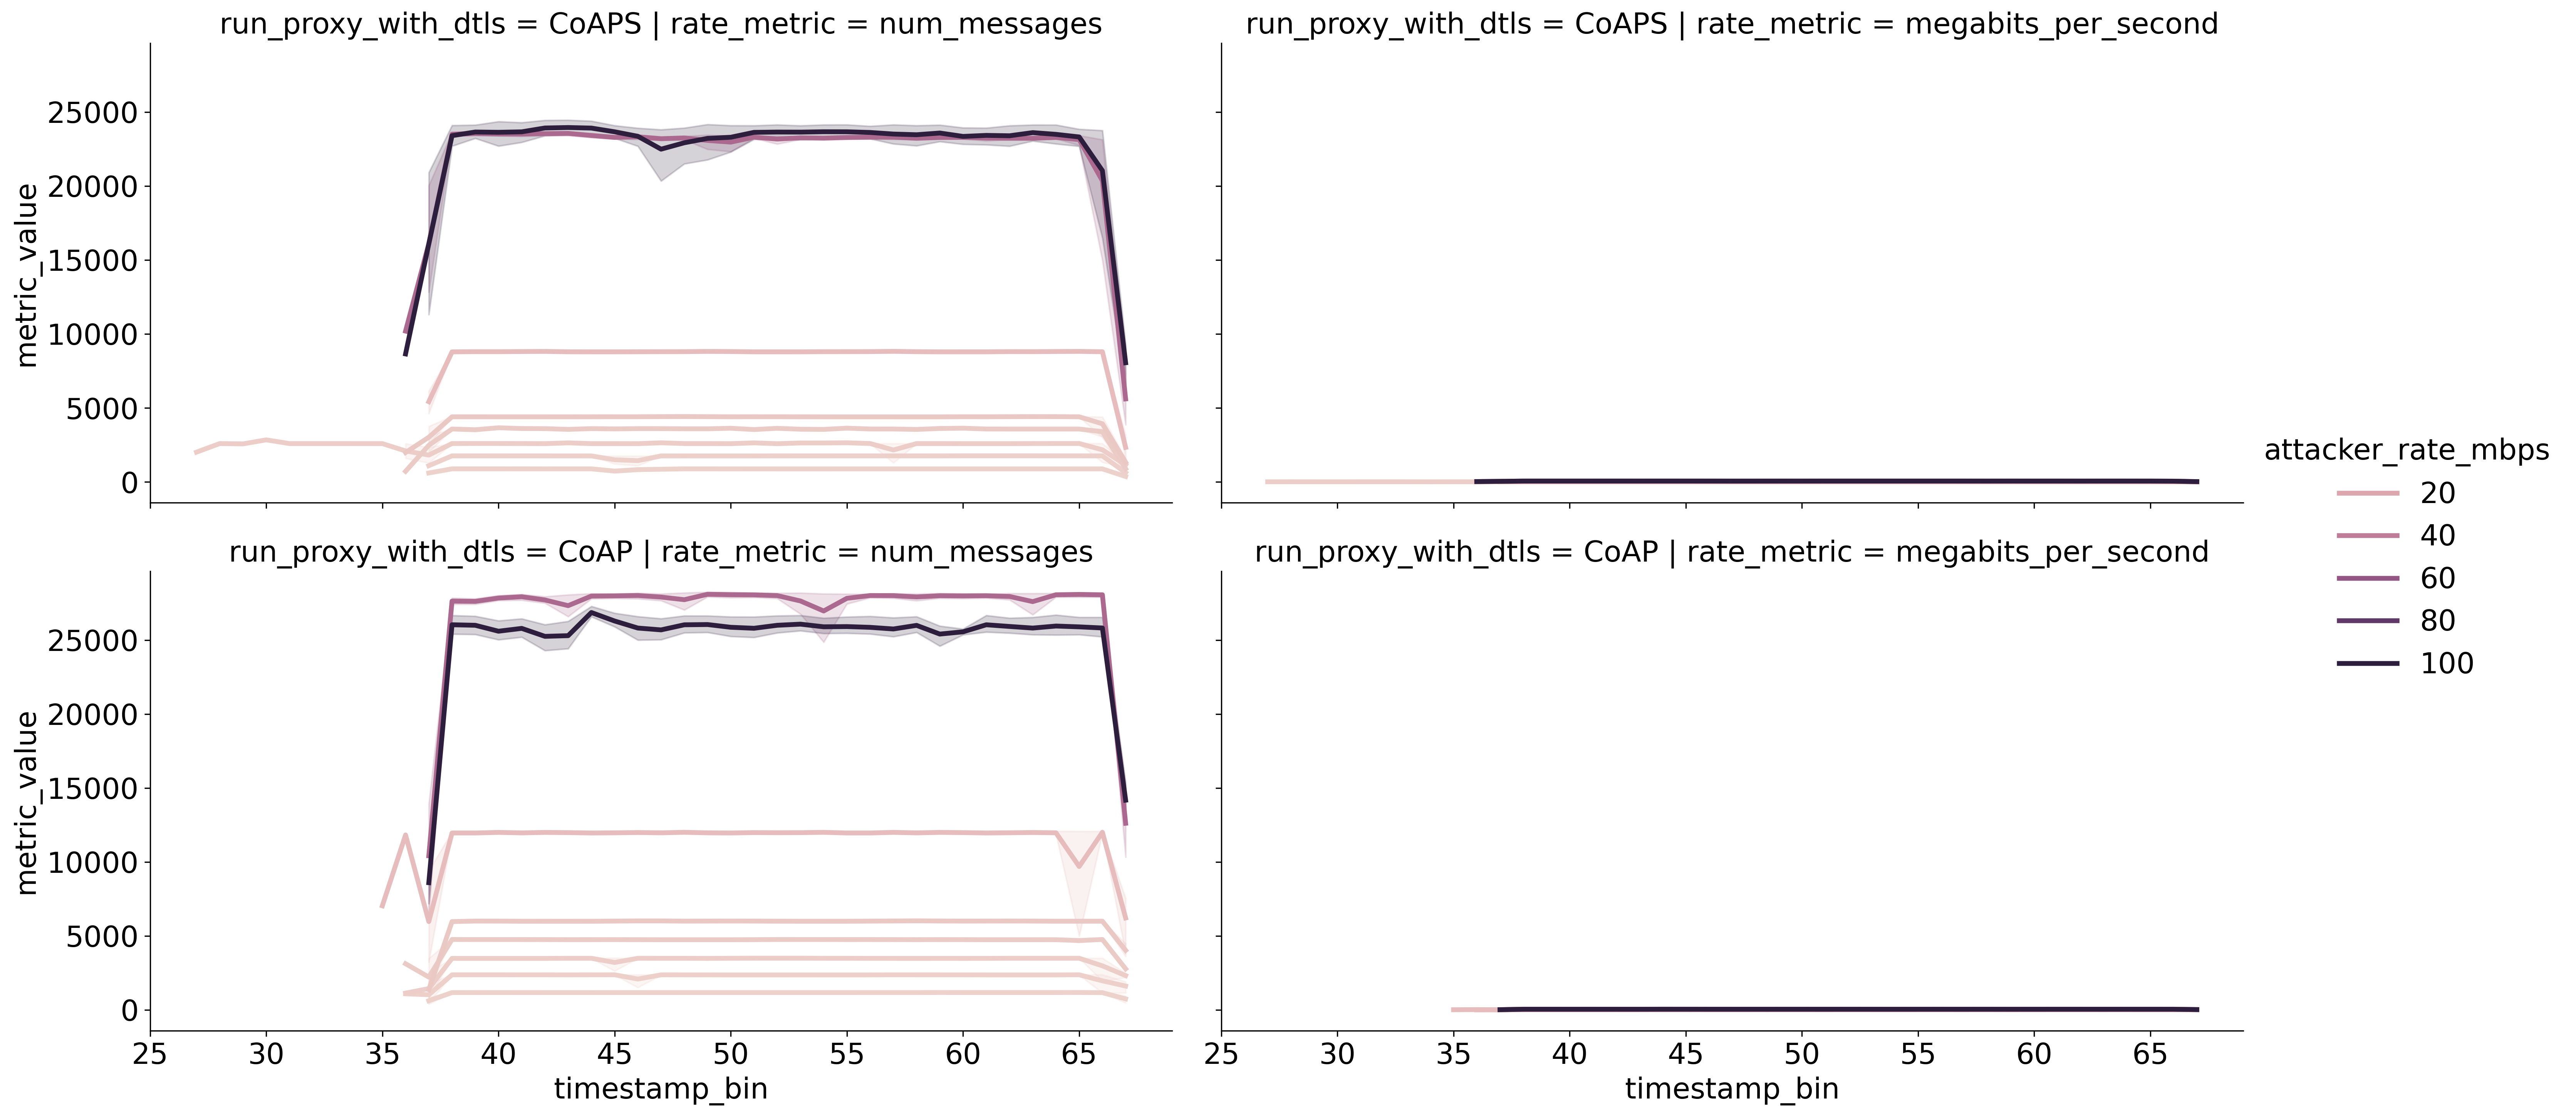

CPU times: user 36.7 s, sys: 593 ms, total: 37.3 s
Wall time: 37 s


In [34]:
%%time

g = sns.relplot(
  kind="line",
  data=melted_filtered_binned_messages_df,
  x="timestamp_bin",
  y="metric_value",
  hue="attacker_rate_mbps",
  row="run_proxy_with_dtls",
  col="rate_metric",
  aspect=2,
  facet_kws={
    "sharey": True,
    "sharex": True,
  },
)

plt.show()

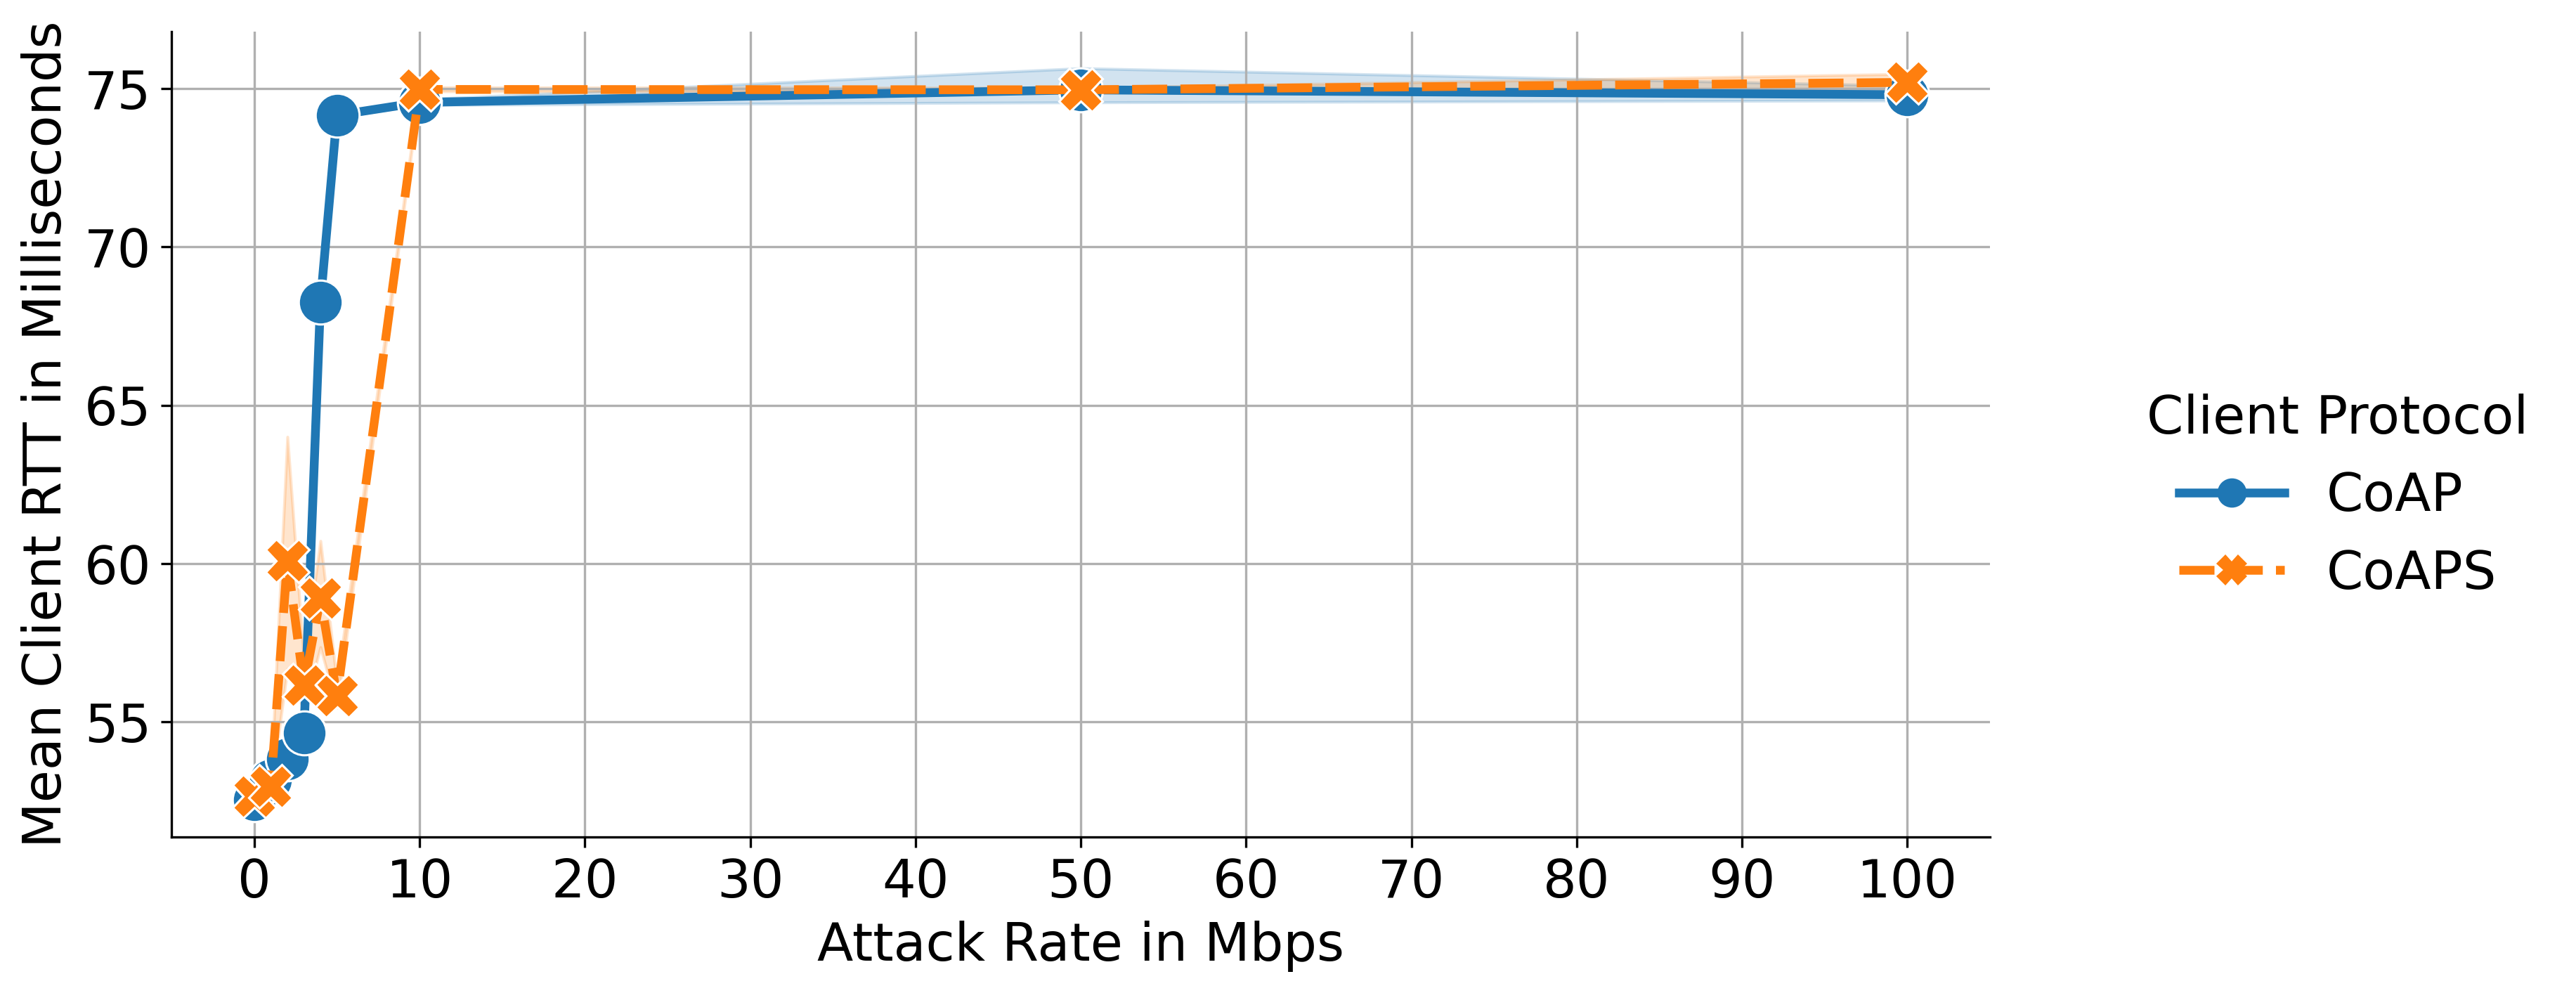

CPU times: user 1.77 s, sys: 184 ms, total: 1.95 s
Wall time: 1.64 s


In [45]:
%%time

### Plot effect of RTT as a result of increasing number of clients

df = client_rps_df

g = sns.relplot(
  data=df,
  kind="line",
  x="attacker_rate_mbps",
  y="mean_rtt_ms",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  markers=True,
  markersize=15,
  aspect=2,
)

g.legend.set_title("Client Protocol")
g.set_xlabels("Attack Rate in Mbps")
g.set_ylabels("Mean Client RTT in Milliseconds")
g.set(
  xticks=np.arange(0, 101, 10)
)

plt.grid(True, axis="both")
plt.show()

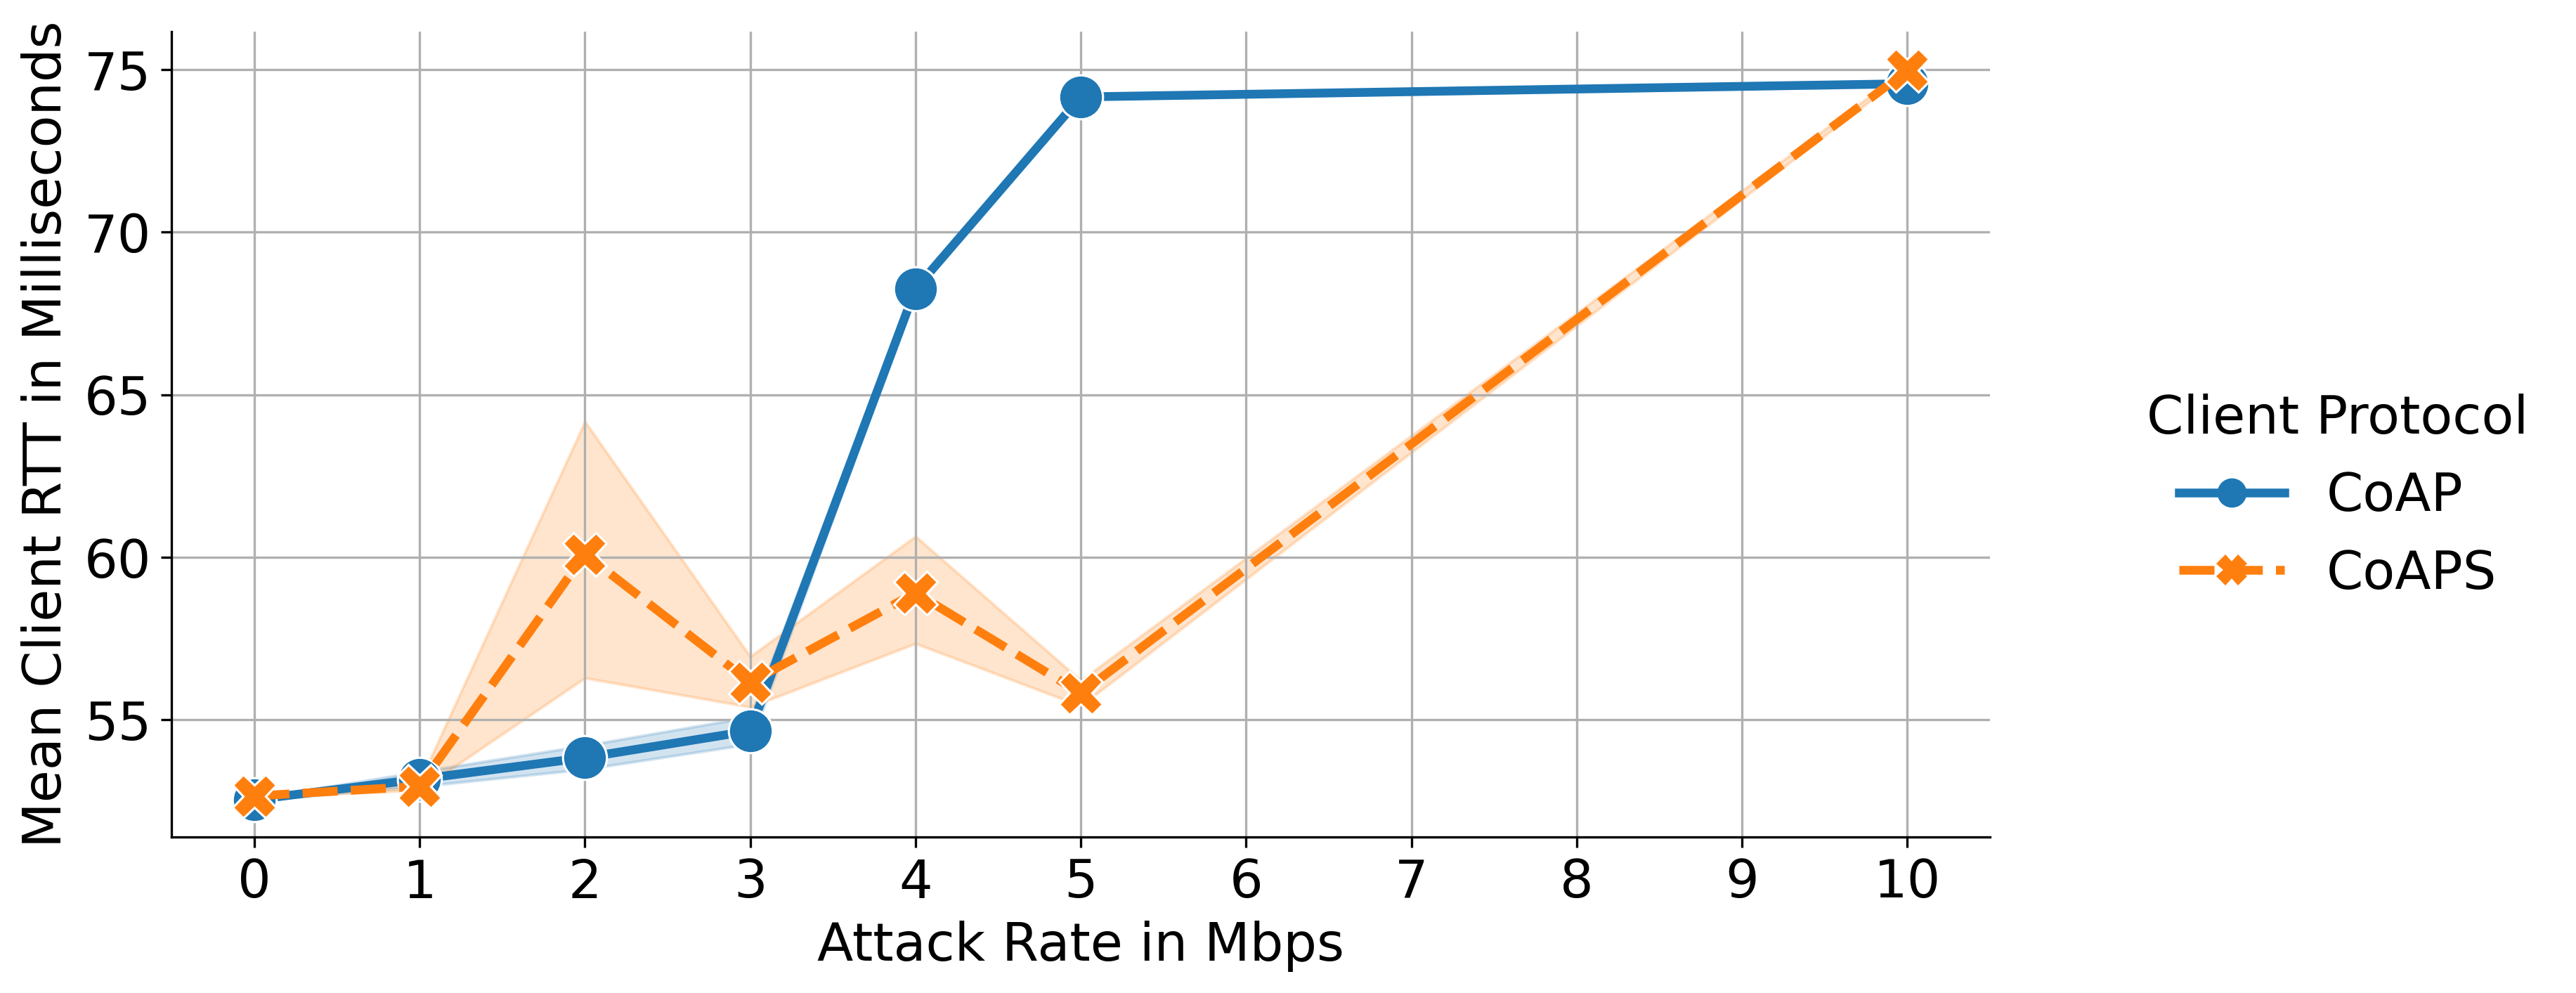

CPU times: user 1.57 s, sys: 196 ms, total: 1.77 s
Wall time: 1.45 s


In [46]:
%%time

### Plot effect of RTT as a result of increasing number of clients

df = (
  client_rps_df[client_rps_df["attacker_rate_mbps"] <= 10]
)

g = sns.relplot(
  data=df,
  kind="line",
  x="attacker_rate_mbps",
  y="mean_rtt_ms",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  markers=True,
  markersize=15,
  aspect=2,
)

g.legend.set_title("Client Protocol")
g.set_xlabels("Attack Rate in Mbps")
g.set_ylabels("Mean Client RTT in Milliseconds")
g.set(
  xticks=np.arange(0, 11, 1)
)

plt.grid(True, axis="both")
plt.show()

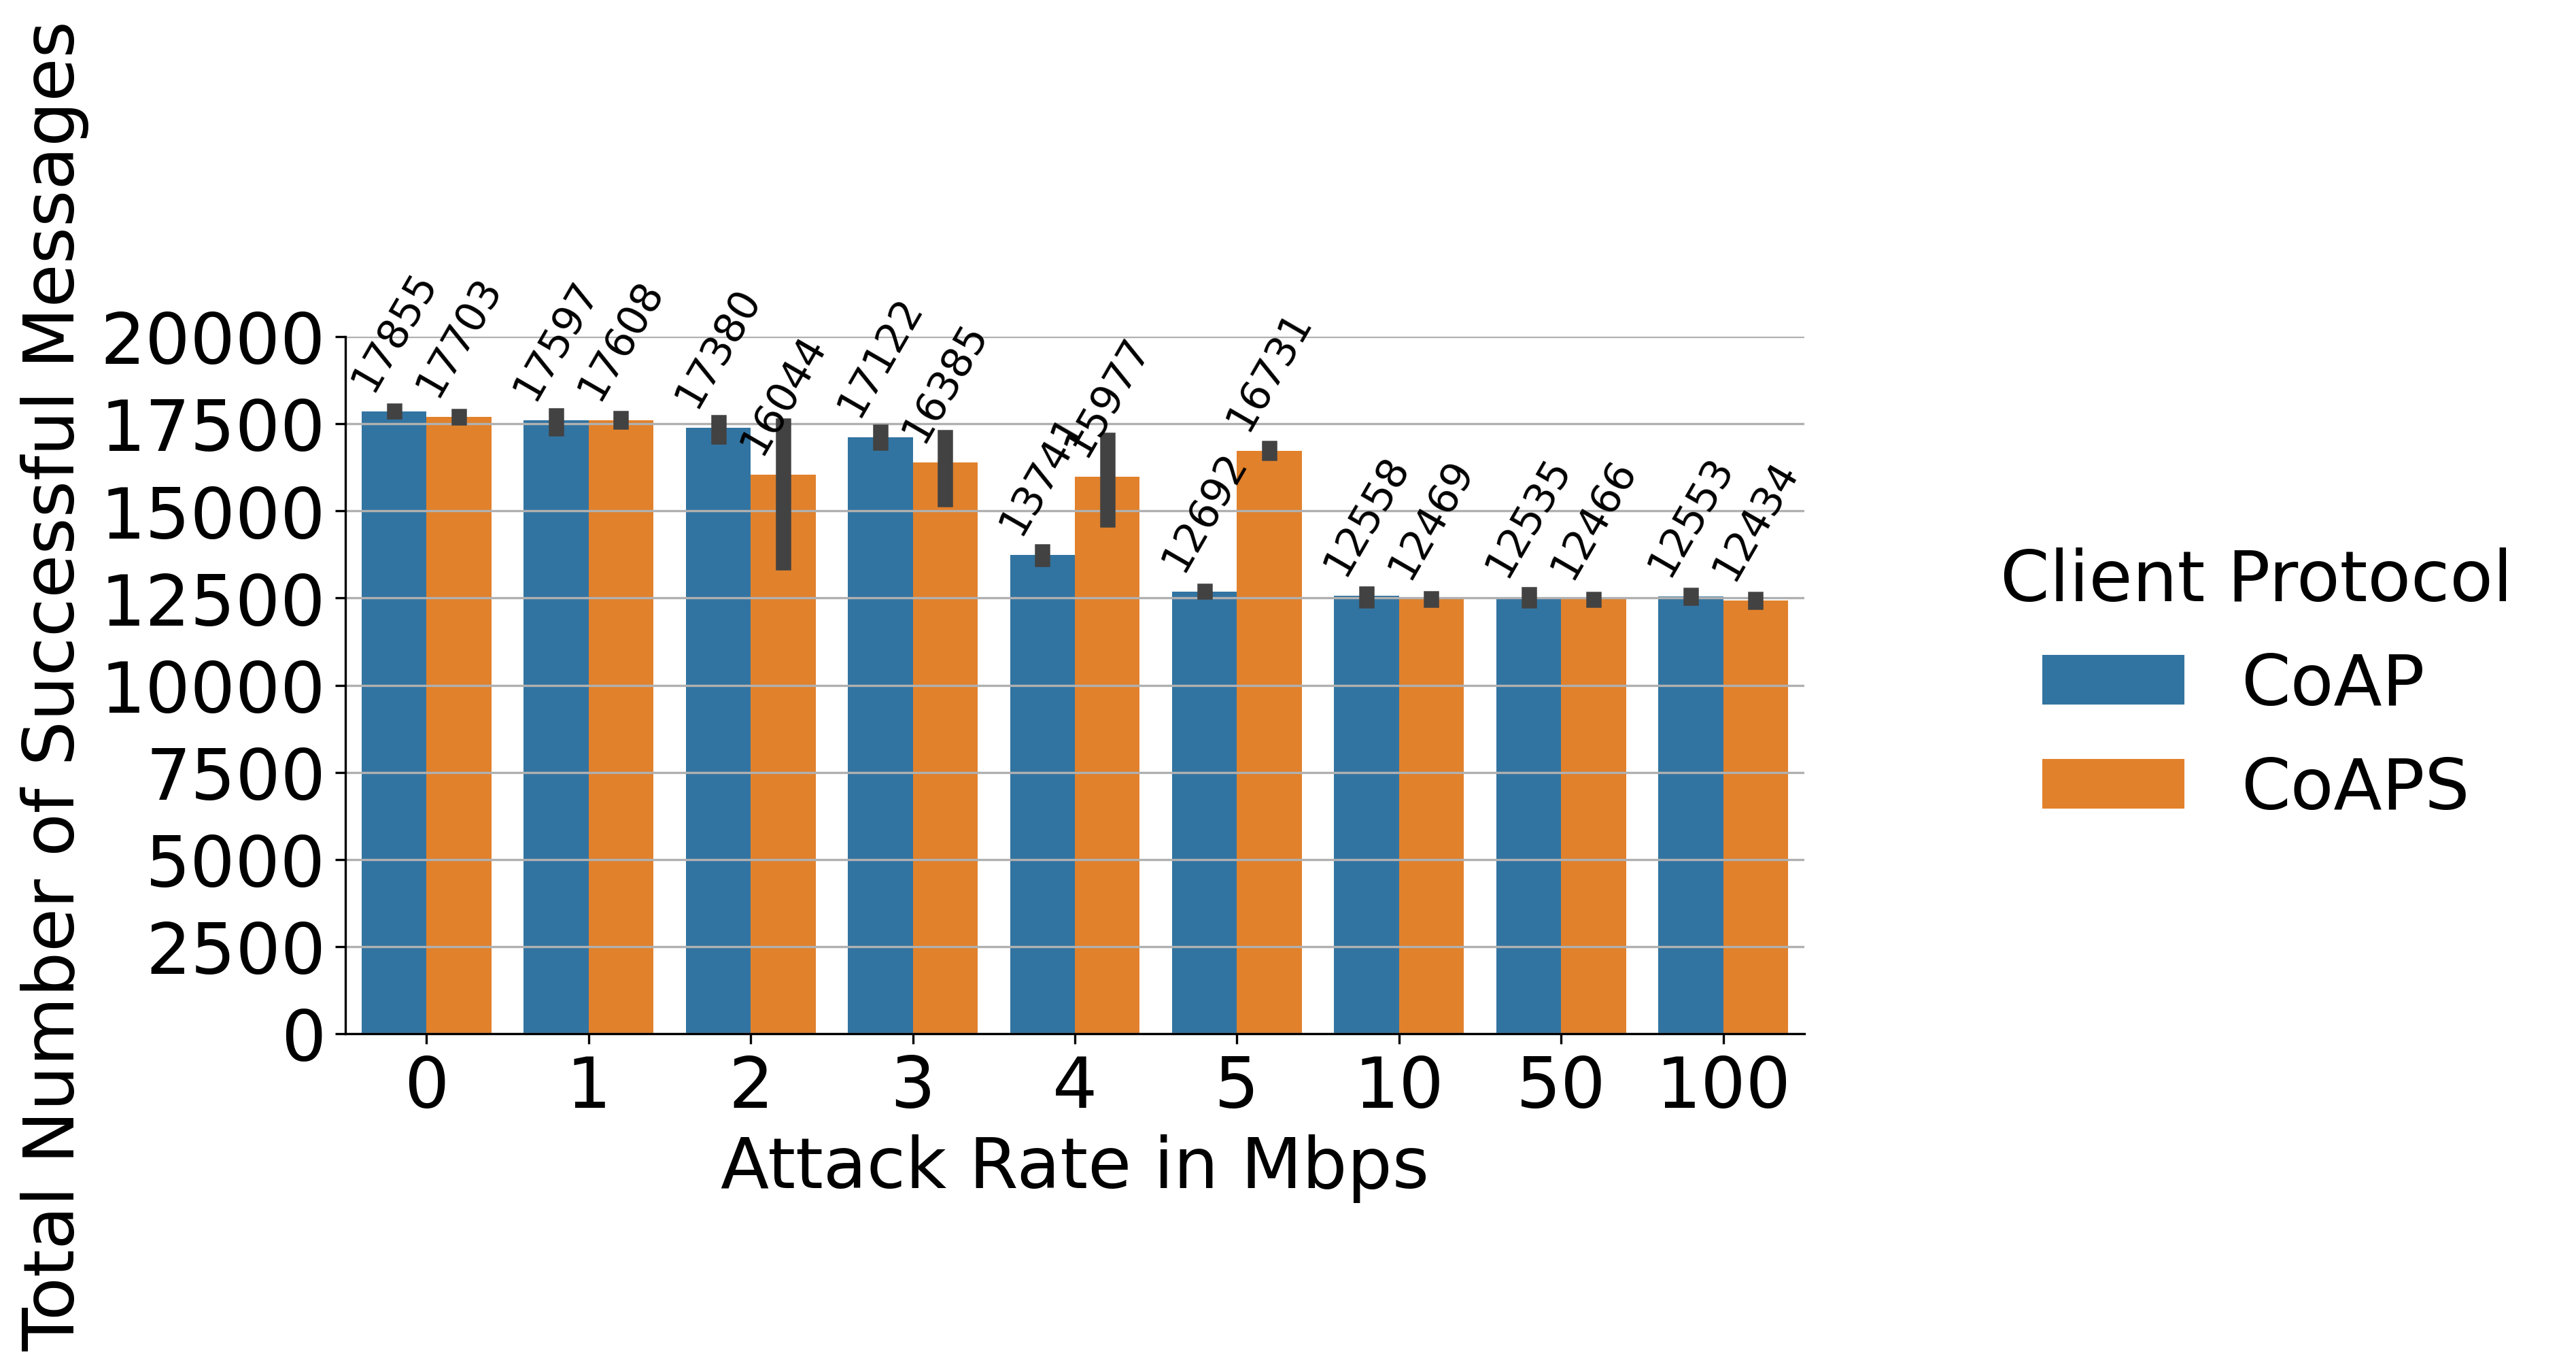

exp_id  \
0   thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1   thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2   thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3   thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4   thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                    ...   
85                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
86                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
87                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
88                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
89                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

   run_proxy_with_dtls  attacker_rate_mbps  trial  total_successful_messages  
0                 CoAP                 100      1                      12472  
1                 CoAP                 100      2                      12559  
2                 CoAP                 100      3                      12600  
3                 CoAP                 100      4                      12560  
4                 CoAP                 100      5                      12575  
..                 ...                 ...    ...                        ...  
85               CoAPS                   0      1                      17706  
86               CoAPS                   0      2                      17691  
87               CoAPS                   0      3                      17682  
88               CoAPS                   0      4                      17715  
89               CoAPS                   0      5                      17724  

[90 rows x 5 columns]

In [60]:
df = (
  client_rps_df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "attacker_rate_mbps", "trial"])
  .agg(
    total_successful_messages=("num_successful_messages", "sum")
  )
  .reset_index()
)

g = sns.catplot(
  data=df,
  x="attacker_rate_mbps",
  y="total_successful_messages",
  hue="run_proxy_with_dtls",
  kind="bar",
  aspect=2,
)

g.set_xlabels("Attack Rate in Mbps")
g.set_ylabels("Total Number of Successful Messages")
g.legend.set_title("Client Protocol")
g.set(
  yticks=np.arange(0, 20_001, 2_500)
)

ax = g.axes[0,0]
for container in ax.containers:
  ax.bar_label(container, fmt="%d", padding=5, rotation=60, fontsize="xx-small")

plt.grid(True, axis="y")

plt.show()

df

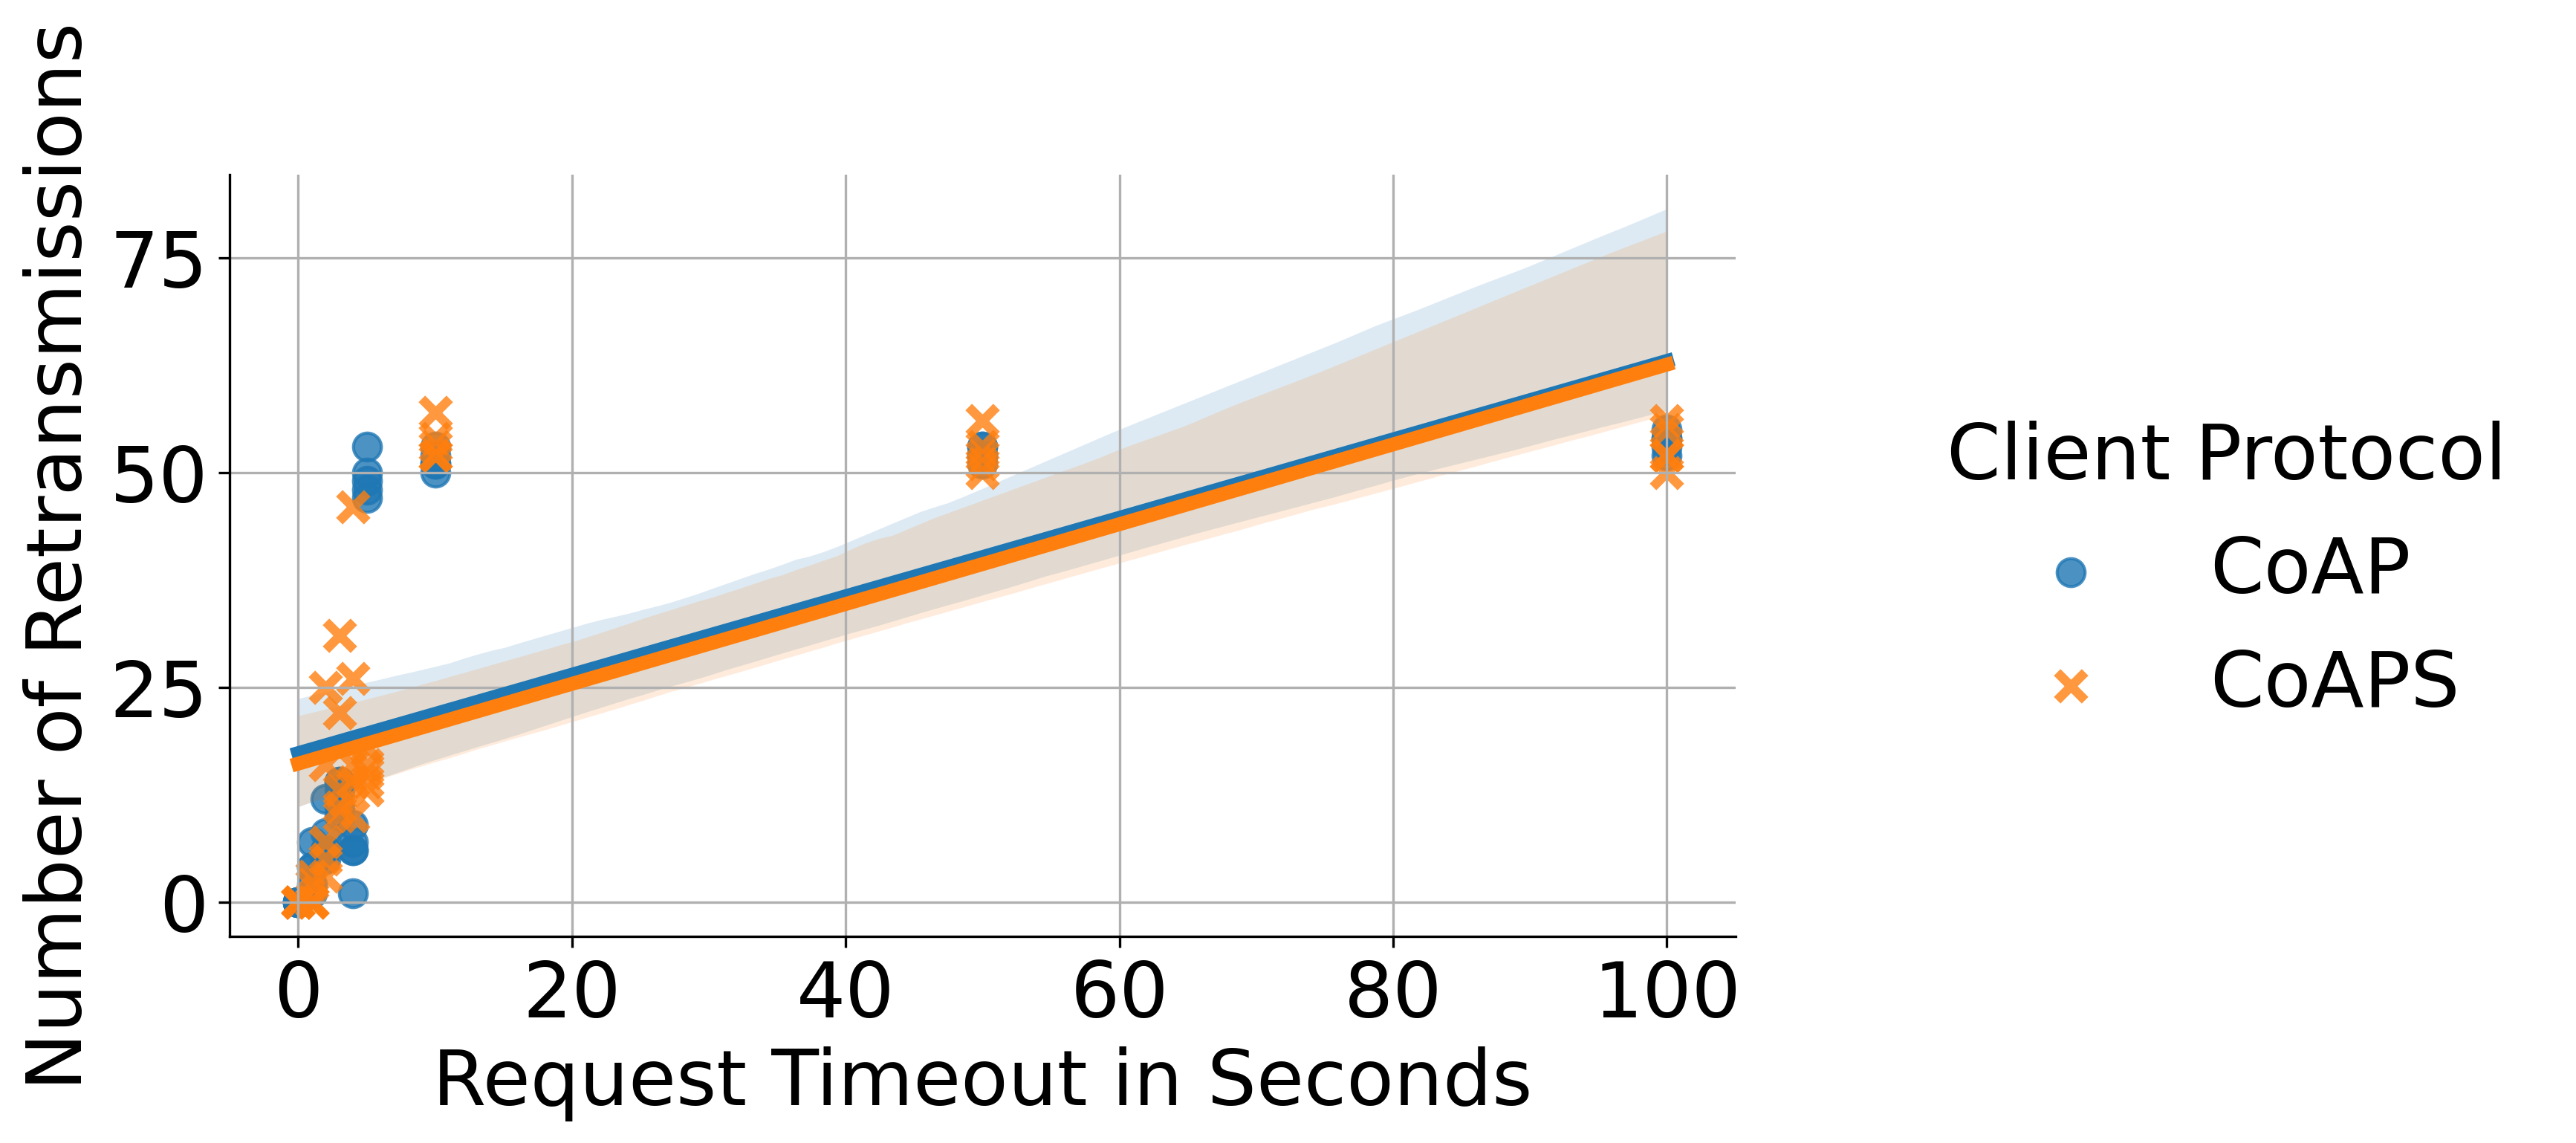

exp_id  \
0   thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1   thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2   thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3   thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4   thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                    ...   
75    thesis_group_attack_rate_impact_5mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
76    thesis_group_attack_rate_impact_5mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
77    thesis_group_attack_rate_impact_5mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
78    thesis_group_attack_rate_impact_5mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
79    thesis_group_attack_rate_impact_5mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

    trial  num_clients  attacker_rate_mbps run_proxy_with_dtls  \
0       1            8                 100                CoAP   
1       2            8                 100                CoAP   
2       3            8                 100                CoAP   
3       4            8                 100                CoAP   
4       5            8                 100                CoAP   
..    ...          ...                 ...                 ...   
75      1            8                   5               CoAPS   
76      2            8                   5               CoAPS   
77      3            8                   5               CoAPS   
78      4            8                   5               CoAPS   
79      5            8                   5               CoAPS   

    total_num_retransmissions  
0                          55  
1                          54  
2                          54  
3                          53  
4                          52  
..                        ...  
75                         14  
76                         15  
77                         13  
78                         18  
79                         16  

[77 rows x 6 columns]

In [56]:
## Plot retransmissions as a function of clients and protocol.

df = (
  client_rps_df.groupby(by=["exp_id", "trial", "num_clients", "attacker_rate_mbps", "run_proxy_with_dtls"])
  .agg(
    total_num_retransmissions=("total_num_retransmissions", "sum")
  )
  .reset_index()
)

g = sns.lmplot(
  data=df,
  x="attacker_rate_mbps",
  y="total_num_retransmissions",
  hue="run_proxy_with_dtls",
  markers=["o", "x"],
  scatter=True,
  aspect=1.75,
)

g.set_xlabels("Request Timeout in Seconds")
g.set_ylabels("Number of Retransmissions")
g.legend.set_title("Client Protocol")

plt.grid(True, axis="both")

plt.show()

df[df["total_num_retransmissions"] > 0]

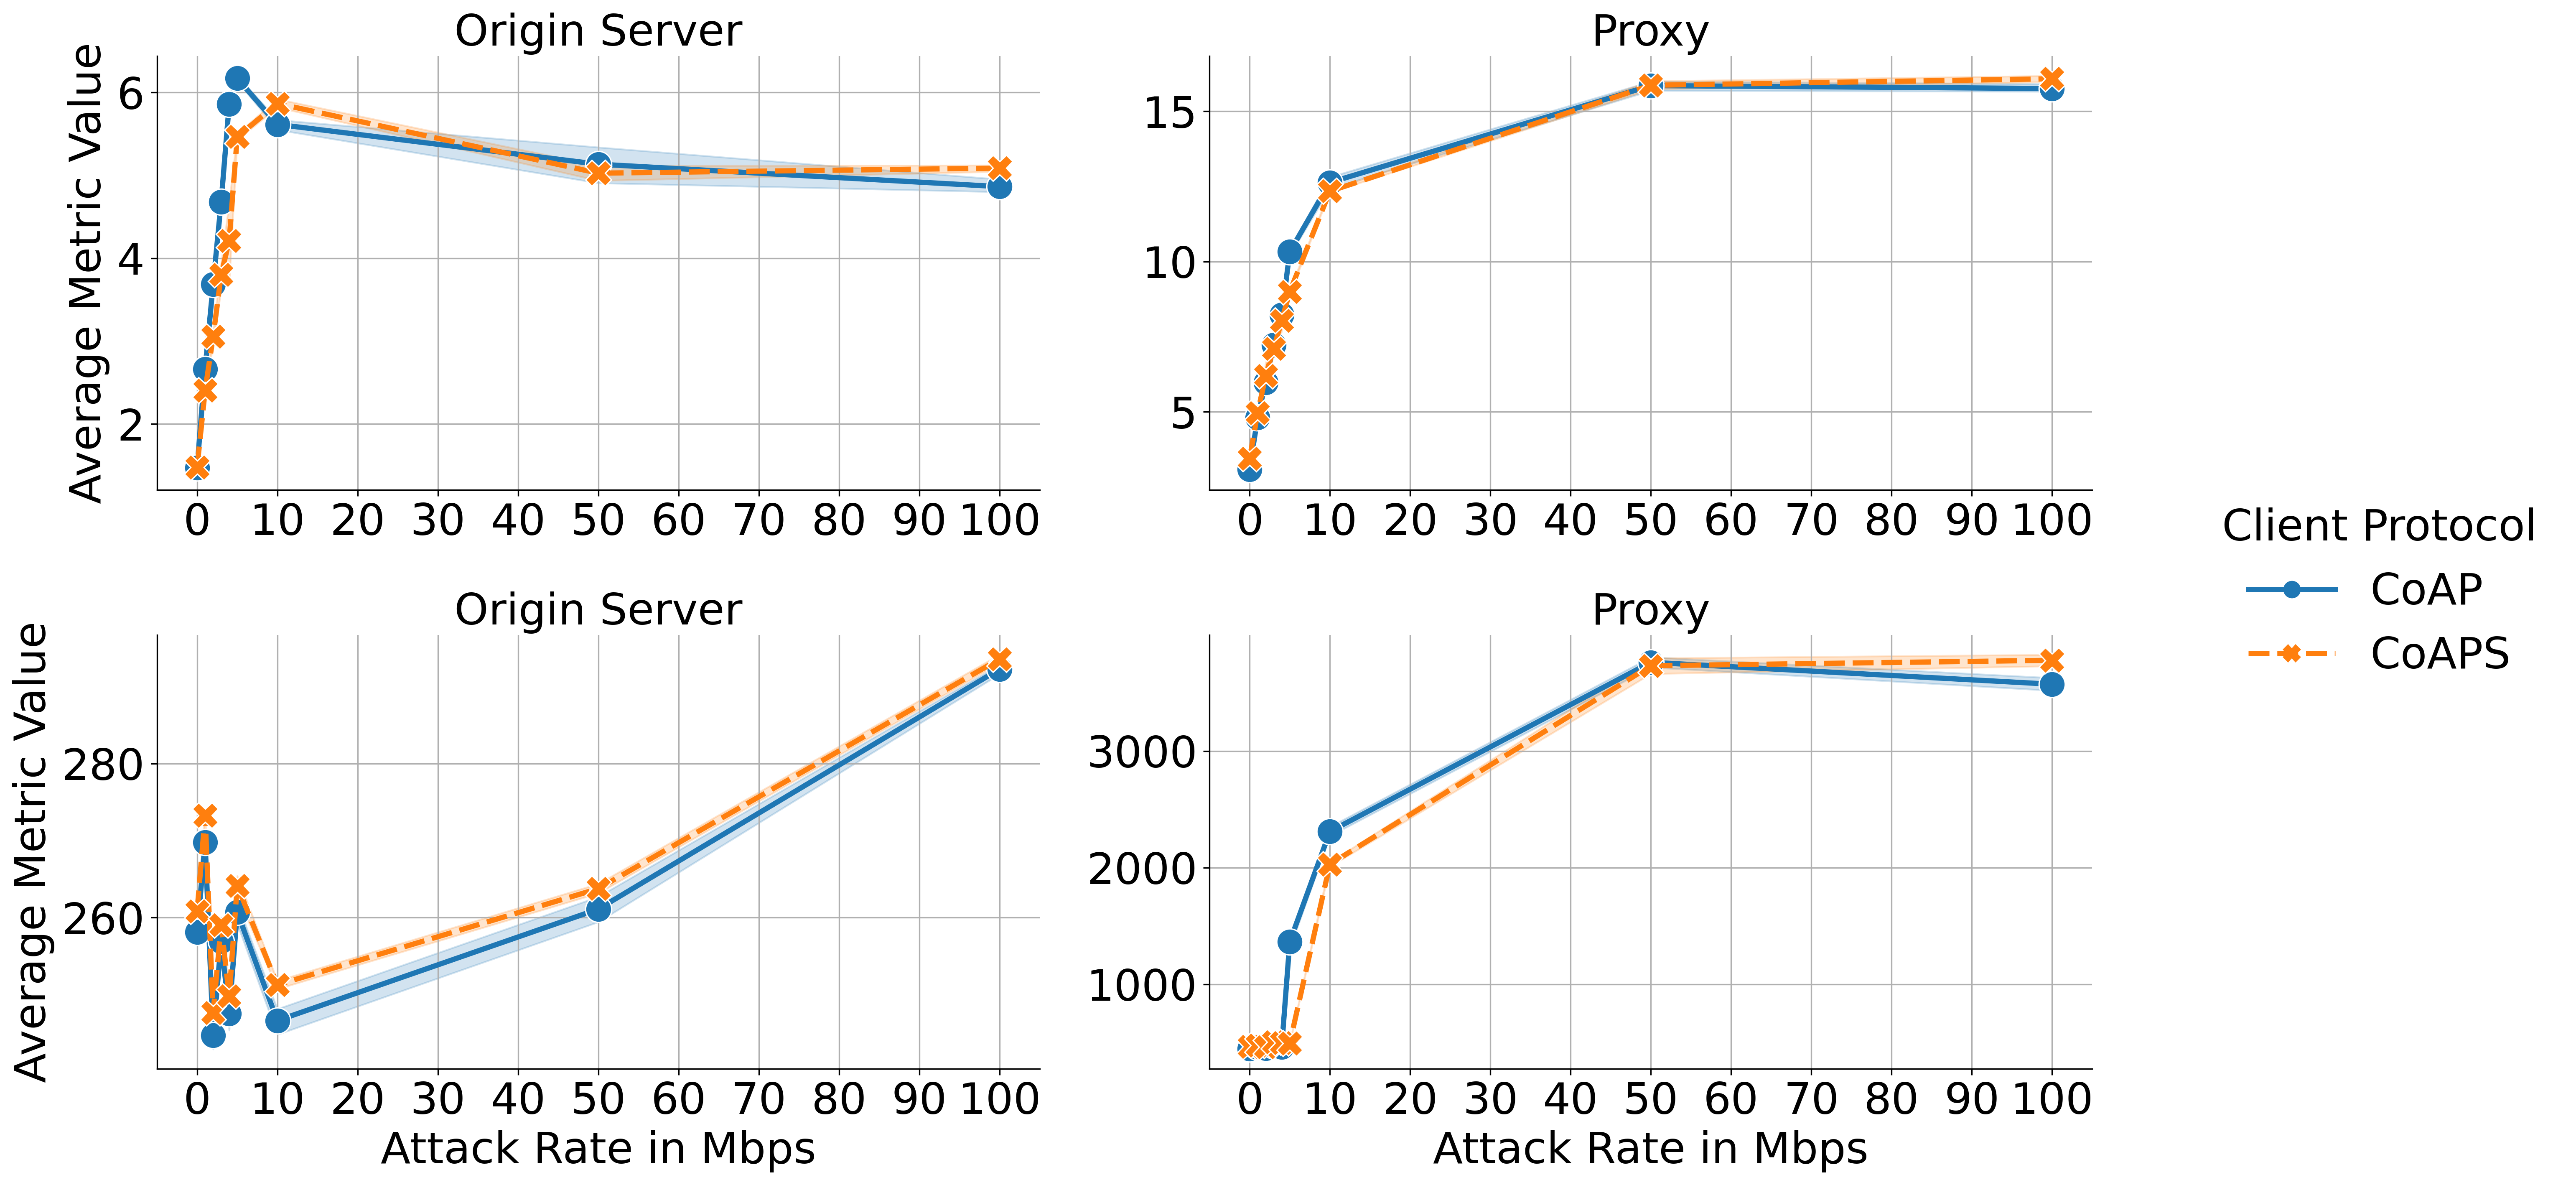

CPU times: user 5.83 s, sys: 362 ms, total: 6.19 s
Wall time: 5.87 s


exp_id  \
0    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                     ...   
355                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
356                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
357                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
358                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
359                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

     trial    observer_id            metric_type    avg_value  min_value  \
0        1  Origin Server      % CPU Utilization     4.782857        0.5   
1        1          Proxy      % CPU Utilization    15.685000        0.4   
2        1  Origin Server  MB Memory Utilization   291.244628      268.0   
3        1          Proxy  MB Memory Utilization  3499.525000      256.0   
4        2  Origin Server      % CPU Utilization     4.847857        0.4   
..     ...            ...                    ...          ...        ...   
355      4          Proxy  MB Memory Utilization   462.127273      245.0   
356      5  Origin Server      % CPU Utilization     1.485714        0.4   
357      5          Proxy      % CPU Utilization     3.462143        0.5   
358      5  Origin Server  MB Memory Utilization   260.966997      247.0   
359      5          Proxy  MB Memory Utilization   466.800000      244.0   

     max_value  attacker_rate  server_connections  max_keep_alive_requests  \
0         22.4            100                 256                        0   
1         86.6            100                 256                        0   
2        308.0            100                 256                        0   
3       5746.0            100                 256                        0   
4         21.4            100                 256                        0   
..         ...            ...                 ...                      ...   
355      495.0              0                 256                        0   
356        9.2              0                 256                        0   
357       26.5              0                 256                        0   
358      262.0              0                 256                        0   
359      503.0              0                 256                        0   

     ...  num_proxy_connections  request_timeout  max_retries  \
0    ...                     50                5            2   
1    ...                     50                5            2   
2    ...                     50                5            2   
3    ...                     50                5            2   
4    ...                     50                5            2   
..   ...                    ...              ...          ...   
355  ...                     50                5            2   
356  ...                     50                5            2   
357  ...                     50                5            2   
358  ...                     50                5            2   
359  ...                     50       

In [61]:
%%time

## Measure proxy and server metrics.

df = (
  metric_df.replace({
    "metric_type": {
      "cpu_utilization": "% CPU Utilization",
      "memory_utilization": "MB Memory Utilization",
    },
    "observer_id": {
      "proxy": "Proxy",
      "originserver": "Origin Server",
    },
  })
)

g = sns.relplot(
  data=df,
  kind="line",
  x="attacker_rate_mbps",
  y="avg_value",
  col="observer_id",
  row="metric_type",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  markers=True,
  markersize=15,
  facet_kws={
    "sharey": False,
    "sharex": False,
  },
  aspect=1.75,
)

g.set_titles(
  template="{col_name}",
  col_template="{col_name}",
  row_template="{row_name}",
)
g.set_xlabels("Attack Rate in Mbps")
g.set_ylabels("Average Metric Value")
g.legend.set_title("Client Protocol")
# g.set(xticks=np.arange(1,9,1))

axes = [
  g.axes[0,0],
  g.axes[0,1],
  g.axes[1,0],
  g.axes[1,1],
]
for ax in axes:
  ax.set_xticks(np.arange(0,101,10))
  ax.grid(True, axis="both")

plt.show()

df

In [51]:
%%time

## Measure proxy and server connection management.
##
## We currently do not insert connection events to
## the database, so we have to read from the processed
## connection files.

ALL_EXPERIMENTS_DATA_HOME = "/home/ubuntu/dos-californium/deter/expdata/real/final"

def read_exp_trial_node_connections(exp_id):
  """
  Read all processed connection dumps in an experiment `exp_id`.
  """
  experiment_dir = os.path.join(ALL_EXPERIMENTS_DATA_HOME, exp_id)

  df = (
    pl
    .scan_parquet(
      f"{experiment_dir}/*/{exp_id}.connections.parquet"
    )
  )
  lazy_dfs.append(df)

lazy_dfs = list()
for exp_id in exp_df["exp_id"].unique():
  read_exp_trial_node_connections(exp_id)

connections_df = (
  pl
  .concat(lazy_dfs)

  # Filter for proxy's view of syn-acks or fin-acks coming from server
  .filter(
    (pl.col("observer_id") == "proxy")
    & ((pl.col("is_syn") == 1) | (pl.col("is_fin") == 1))
    & (pl.col("info").str.contains(", ACK]"))
    & (pl.col("src_port") == 443)
  )
  # Group by experiment, trial, and observer, then accummulate
  # syn-acks and fin-acks in a list, along with their corresponding
  # timestamps of occurrence for each group.
  .groupby(
    by=["exp_id", "trial", "observer_id"],
    maintain_order=True
  )
  .agg([
    pl.col("timestamp").alias("timestamp"),
    pl.col("is_syn").cumsum().alias("cum_syn"),
    pl.col("is_fin").cumsum().alias("cum_fin"),
  ])
  # Explode the cumulative syns and fins, and their times, then
  # subtract them to get a view of how many open connections there
  # are in the experiment as a function of time
  .explode(columns=["timestamp", "cum_syn", "cum_fin"])
  .with_columns([
    (pl.col("cum_syn") - pl.col("cum_fin")).alias("open_connections")
  ])

  # And finally convert to pandas for plotting.
  .collect()
  .to_pandas()
)

# This method of counting does not include the original 0 connections
# at time 0 for each node in each trial -- so we add that manually.
records = list()
for e in connections_df["exp_id"].unique():
  for t in connections_df["trial"].unique():
    for o in connections_df["observer_id"].unique():
      records.append({
        "exp_id"          : e,
        "trial"           : t,
        "observer_id"     : o,
        "timestamp"       : 0.0,
        "cum_syn"         : 0,
        "cum_fin"         : 0,
        "open_connections": 0,
      })
connections_df = (
  pd.concat(
    [connections_df, pd.DataFrame.from_records(records)]
  )
  .sort_values(by=["exp_id", "trial", "observer_id", "timestamp"])
)

# This method also does not include a connection count at the last time
# the proxy is meant to be active -- so we fill that value in based on the
# last value.
last_connection_df = (
  connections_df
  .groupby(by=["exp_id", "trial", "observer_id"], sort=True)
  .agg(
    max_timestamp=("timestamp", "max"),
    last_timestamp=("timestamp", "last"),
    max_open_connections=("open_connections", "max"),
    last_open_connections=("open_connections", "last"),
    last_cum_syn=("cum_syn", "last"),
    last_cum_fin=("cum_fin", "last"),
  )
  .reset_index()
)
# assert last_connection_df["max_timestamp"].equals(last_connection_df["last_timestamp"])
# assert last_connection_df["max_open_connections"].equals(last_connection_df["last_open_connections"])
records = list()
for r in last_connection_df.to_dict(orient="records"):
  records.append({
    "exp_id"          : r["exp_id"],
    "trial"           : r["trial"],
    "observer_id"     : r["observer_id"],
    "timestamp"       : 140,
    "cum_syn"         : r["last_cum_syn"],
    "cum_fin"         : r["last_cum_fin"],
    "open_connections": r["last_open_connections"],
  })
connections_df = (
  pd.concat(
    [connections_df, pd.DataFrame.from_records(records)]
  )
  .sort_values(by=["exp_id", "trial", "observer_id", "timestamp"])
)

connections_df = (
  connections_df
  .merge(exp_df, on="exp_id", how="left")
  .replace(value_map_replacement)
)

connections_df

CPU times: user 54.7 s, sys: 3min 12s, total: 4min 6s
Wall time: 16 s


exp_id  \
0      thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1      thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2      thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3      thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4      thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                      ...   
10300                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
10301                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
10302                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
10303                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
10304                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

       trial observer_id   timestamp  cum_syn  cum_fin  open_connections  \
0          1       proxy    0.000000        0        0                 0   
1          1       proxy    0.064125        1        0                 1   
2          1       proxy    1.034171        2        0                 2   
3          1       proxy    4.259069        3        0                 3   
4          1       proxy    6.267311        4        0                 4   
...      ...         ...         ...      ...      ...               ...   
10300      5       proxy  128.476332       13       10                 3   
10301      5       proxy  129.492474       13       11                 2   
10302      5       proxy  130.518600       13       12                 1   
10303      5       proxy  131.533649       13       13                 0   
10304      5       proxy  140.000000       13       13                 0   

       attacker_rate  server_connections  max_keep_alive_requests  ...  \
0                100                 256                        0  ...   
1                100                 256                        0  ...   
2                100                 256                        0  ...   
3                100                 256                        0  ...   
4                100                 256                        0  ...   
...              ...                 ...                      ...  ...   
10300              0                 256                        0  ...   
10301              0                 256                        0  ...   
10302              0                 256                        0  ...   
10303              0                 256                        0  ...   
10304              0                 256                        0  ...   

       num_proxy_connections  request_timeout  max_retries  \
0                         50                5            2   
1                         50                5            2   
2                         50                5            2   
3                         50                5            2   
4                         50                5            2   
...                      ...              ...          ...   
10300                     50                5            2   
10301                     50                5            2   
10302                     50                5            2   
10303                     50                5            2   
10304                     50                5            2   

       keep_alive_duration  reques

In [53]:
%%time

## Measure proxy and server connection management.

df = connections_df

plt.rcParams['font.size'] = '25'

g = sns.relplot(
  data=df,
  kind="line",
  x="timestamp",
  y="open_connections",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  col="attacker_rate_mbps",
  col_wrap=2,
  markers=True,
  markersize=20,
  facet_kws={
    "sharey": True,
    "sharex": True,
  },
  aspect=2,
)
g.set_xlabels("Timestamp in Seconds")
g.set_ylabels("Open Connections", labelpad=20)
g.legend.set_title("Client Protocol")
# g.set(yticks=np.arange(1,9,1))
# for i in range(8):
#   g.axes[i].grid(True, axis="both")

plt.show()

CPU times: user 13.8 s, sys: 714 ms, total: 14.5 s
Wall time: 14.2 s


In [64]:
%%time 

client_journey_sql = f"""
WITH client_sends AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observer_id AS observer_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker
  FROM event e
  JOIN message m ON m.message_id = e.message_id
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
  AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
),

proxy_events AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker
  FROM event e
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, proxy_dnids))})   -- proxy dnids
),

client_recvs AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observer_id AS observer_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker,
  cm.coap_code AS coap_code
  FROM event e
  JOIN message m ON m.message_id = e.message_id
  JOIN coap_message cm ON cm.cmci = m.coap_message
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
  AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT
  client_sends.exp_id AS exp_id,
  client_sends.observer_id AS observer_id,
  client_sends.trial AS trial,
  client_sends.message_marker AS message_marker,
  (groupArray(client_recvs.coap_code))[1] AS coap_code,
  MIN(client_sends.observe_timestamp) AS first_send_time_sec,
  abs(1e3 * (MIN(proxy_events.observe_timestamp) - MIN(client_sends.observe_timestamp))) AS client_to_proxy_ms,
  1e3 * (MAX(client_recvs.observe_timestamp) - MIN(proxy_events.observe_timestamp)) AS proxy_to_client_ms,
  1e3 * (MAX(client_recvs.observe_timestamp) - MIN(client_sends.observe_timestamp)) AS client_to_self_rtt_ms,
  MIN(client_recvs.observe_timestamp) AS first_recv_time_sec
FROM
  client_sends
  JOIN proxy_events
    ON proxy_events.exp_id = client_sends.exp_id
    AND proxy_events.trial = client_sends.trial
    AND proxy_events.message_marker = client_sends.message_marker
  JOIN client_recvs
    ON client_recvs.exp_id = proxy_events.exp_id
    AND client_recvs.trial = proxy_events.trial
    AND client_recvs.message_marker = proxy_events.message_marker
    AND client_recvs.observer_id = client_sends.observer_id
GROUP BY
  client_sends.exp_id, client_sends.observer_id, client_sends.trial, client_sends.message_marker
ORDER BY
  exp_id, trial, message_marker, first_send_time_sec
"""

client_journey_df = client.query_dataframe(client_journey_sql)

client_journey_df.observer_id.replace(dnid_map_node_name, inplace=True)

client_journey_df

CPU times: user 4.26 s, sys: 1.67 s, total: 5.93 s
Wall time: 1min 6s


exp_id  \
0        thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1        thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2        thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3        thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4        thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                        ...   
1360239                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1360240                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1360241                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1360242                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
1360243                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

        observer_id  trial  message_marker coap_code  first_send_time_sec  \
0           client1      1               1   content             0.000000   
1           client1      1               2   content             0.364401   
2           client1      1               3   content             0.426992   
3           client1      1               4   content             0.489618   
4           client1      1               5   content             0.550316   
...             ...    ...             ...       ...                  ...   
1360239     client8      5           17772   content           125.663703   
1360240     client8      5           17773   content           125.717236   
1360241     client8      5           17774   content           125.770620   
1360242     client8      5           17775   content           125.823910   
1360243     client8      5           17776   content           125.877252   

         client_to_proxy_ms  proxy_to_client_ms  client_to_self_rtt_ms  \
0                 20.381927          328.616858             348.998785   
1                 20.359039           40.132999              60.492039   
2                 20.406008           39.967060              60.373068   
3                 20.298004           37.987947              58.285952   
4                 20.368099           36.330938              56.699038   
...                     ...                 ...                    ...   
1360239           21.526814           31.218052              52.744865   
1360240           21.502972           31.090021              52.592993   
1360241           21.459103           31.073809              52.532911   
1360242           21.476984           31.013012              52.489996   
1360243           21.477938           31.113148              52.591085   

         first_recv_time_sec  
0                   0.348999  
1                   0.424893  
2                   0.487365  
3                   0.547904  
4                   0.607015  
...                      ...  
1360239           125.716448  
1360240           125.769829  
1360241           125.823153  
1360242           125.876400  
1360243           125.929843  

[1360244 rows x 10 columns]

In [70]:
%%time

# `client_journey_df` is far too detailed for plotting, but
# is useful for non-plotting use-cases so we keep it around.
# But for plotting, we summarize RTTs in discrete intervals
# of time instead, thus reducing the amount of data.

reduced_client_journey_df = (
  client_journey_df
  .groupby(by=[
    "exp_id", "observer_id", "trial",
    pd.cut(client_journey_df["first_send_time_sec"], np.arange(0,121,5))
  ])
  .agg(
    client_to_self_rtt_ms=("client_to_self_rtt_ms", "mean"),
  )
  .reset_index()
  .melt(
    id_vars=["exp_id", "observer_id", "trial", "first_send_time_sec"],
    value_vars=["client_to_self_rtt_ms"],
    var_name="sub_journey_name",
    value_name="sub_journey_time_ms",
  )
)

reduced_client_journey_df["first_send_time_sec"] = reduced_client_journey_df["first_send_time_sec"].map(operator.attrgetter("right"))
reduced_client_journey_df = reduced_client_journey_df.merge(exp_df, on="exp_id", how="left")

reduced_client_journey_df

CPU times: user 834 ms, sys: 4.89 ms, total: 838 ms
Wall time: 836 ms


exp_id  \
0      thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1      thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2      thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3      thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4      thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                      ...   
17275                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
17276                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
17277                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
17278                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
17279                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

      observer_id  trial first_send_time_sec       sub_journey_name  \
0         client1      1                   5  client_to_self_rtt_ms   
1         client1      1                  10  client_to_self_rtt_ms   
2         client1      1                  15  client_to_self_rtt_ms   
3         client1      1                  20  client_to_self_rtt_ms   
4         client1      1                  25  client_to_self_rtt_ms   
...           ...    ...                 ...                    ...   
17275     client8      5                 100  client_to_self_rtt_ms   
17276     client8      5                 105  client_to_self_rtt_ms   
17277     client8      5                 110  client_to_self_rtt_ms   
17278     client8      5                 115  client_to_self_rtt_ms   
17279     client8      5                 120  client_to_self_rtt_ms   

       sub_journey_time_ms  attacker_rate  server_connections  \
0                55.271730            100                 256   
1                53.590327            100                 256   
2                53.153191            100                 256   
3                53.092941            100                 256   
4                53.321082            100                 256   
...                    ...            ...                 ...   
17275            52.928481              0                 256   
17276            52.644803              0                 256   
17277            52.358574              0                 256   
17278            52.358881              0                 256   
17279            52.603942              0                 256   

       max_keep_alive_requests  num_clients  ...  num_proxy_connections  \
0                            0            8  ...                     50   
1                            0            8  ...                     50   
2                            0            8  ...                     50   
3                            0            8  ...                     50   
4                            0            8  ...                     50   
...                        ...          ...  ...                    ...   
17275                        0            8  ...                     50   
17276                        0            8  ...                     50   
17277                        0            8  ...                     50   
17278                        0            8  ...                     50   
17279                        0            8  ...                     50   

       request_timeout  max_retries  keep_aliv

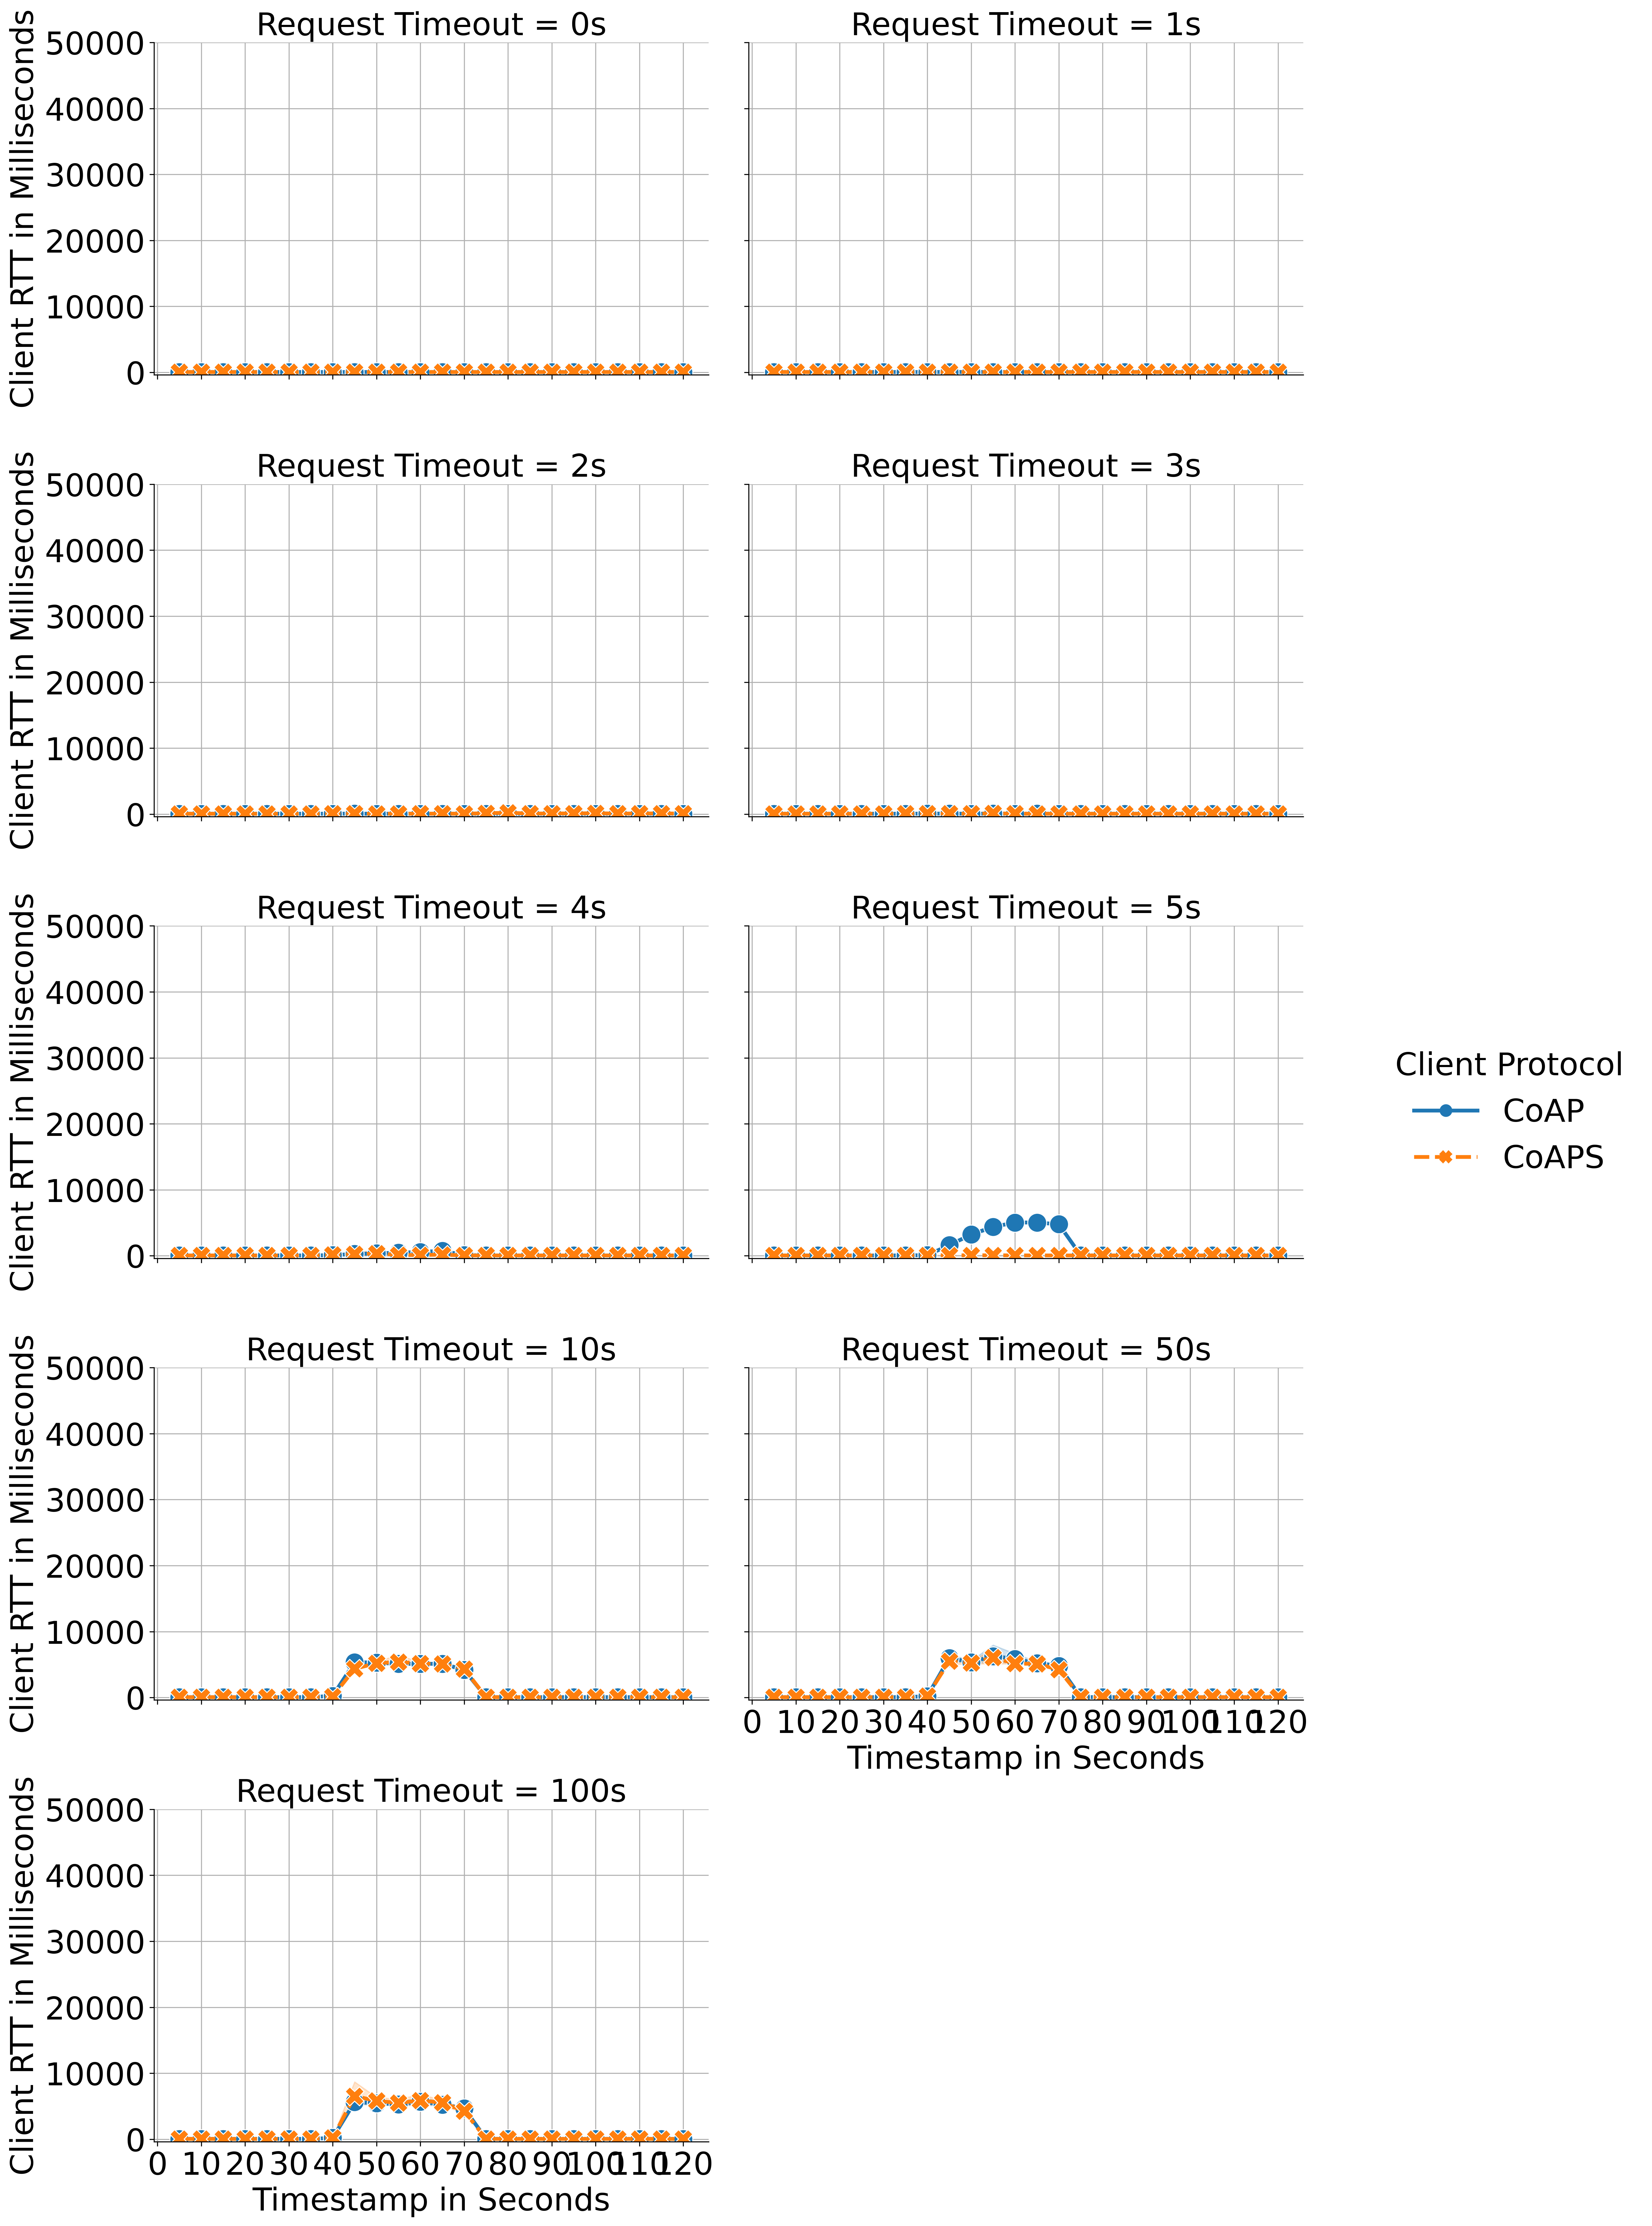

CPU times: user 20.3 s, sys: 317 ms, total: 20.6 s
Wall time: 20.3 s


exp_id  \
0      thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1      thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2      thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3      thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4      thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                      ...   
17275                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
17276                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
17277                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
17278                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   
17279                   thesis_group_num_clients_dtls_https_8clients_noattacker__140sec_proxy__30sec_attacker__120sec_client   

      observer_id  trial first_send_time_sec       sub_journey_name  \
0         client1      1                   5  client_to_self_rtt_ms   
1         client1      1                  10  client_to_self_rtt_ms   
2         client1      1                  15  client_to_self_rtt_ms   
3         client1      1                  20  client_to_self_rtt_ms   
4         client1      1                  25  client_to_self_rtt_ms   
...           ...    ...                 ...                    ...   
17275     client8      5                 100  client_to_self_rtt_ms   
17276     client8      5                 105  client_to_self_rtt_ms   
17277     client8      5                 110  client_to_self_rtt_ms   
17278     client8      5                 115  client_to_self_rtt_ms   
17279     client8      5                 120  client_to_self_rtt_ms   

       sub_journey_time_ms  attacker_rate  server_connections  \
0                55.271730            100                 256   
1                53.590327            100                 256   
2                53.153191            100                 256   
3                53.092941            100                 256   
4                53.321082            100                 256   
...                    ...            ...                 ...   
17275            52.928481              0                 256   
17276            52.644803              0                 256   
17277            52.358574              0                 256   
17278            52.358881              0                 256   
17279            52.603942              0                 256   

       max_keep_alive_requests  num_clients  ...  num_proxy_connections  \
0                            0            8  ...                     50   
1                            0            8  ...                     50   
2                            0            8  ...                     50   
3                            0            8  ...                     50   
4                            0            8  ...                     50   
...                        ...          ...  ...                    ...   
17275                        0            8  ...                     50   
17276                        0            8  ...                     50   
17277                        0            8  ...                     50   
17278                        0            8  ...                     50   
17279                        0            8  ...                     50   

       request_timeout  max_retries  keep_aliv

In [71]:
%%time

## Plot different stages of the client round-trip.

df = (
  reduced_client_journey_df[
    reduced_client_journey_df["sub_journey_name"] == "client_to_self_rtt_ms"
  ]
  .replace(value_map_replacement)
)

g = sns.relplot(
  data=df,
  kind="line",
  x="first_send_time_sec",
  y="sub_journey_time_ms",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  col="attacker_rate_mbps",
  col_wrap=2,
  markers=True,
  markersize=15,
  aspect=1.5,
)

g.set_xlabels("Timestamp in Seconds")
g.set_ylabels("Client RTT in Milliseconds")
g.legend.set_title("Client Protocol")

g.set_titles(
  template="Request Timeout = {col_name}s",
  col_template="{col_name}",
  row_template="{row_name}",
)

g.set(
  yticks=np.arange(0,50_001, 10_000),
  xticks=np.arange(0, 121, 10),
)

for i in range(len(df["attacker_rate_mbps"].unique())):
  g.axes[i].grid(True, axis="both")
plt.show()

df

In [67]:
%%time

attacker_message_sql = f"""
WITH attacker_recvs AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observer_id AS observer_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker,
  cm.coap_code AS coap_code
  FROM event e
  JOIN message m ON m.message_id = e.message_id
  JOIN coap_message cm ON cm.cmci = m.coap_message
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, attacker_dnids))})   -- attacker dnids
  AND m.dst_id IN ({','.join(map(str, attacker_node_ids))}) -- attackers are receivers (node ID)
),

attacker_response_breakdown AS (
  SELECT
    exp_id,
    trial,
    observer_id,
    coap_code AS response_code,
    COUNT(coap_code) AS response_code_count
  FROM
    attacker_recvs
  GROUP BY
    exp_id, trial, observer_id, response_code
  ORDER BY
    exp_id, trial, observer_id, response_code
),

attacker_response_count AS (
  SELECT
    exp_id,
    trial,
    observer_id,
    SUM(response_code_count) AS response_count
  FROM
    attacker_response_breakdown
  GROUP BY
    exp_id, trial, observer_id
  ORDER BY
    exp_id, trial, observer_id
)

SELECT * FROM attacker_response_breakdown
"""

attacker_message_df = client.query_dataframe(attacker_message_sql)

attacker_message_df.observer_id.replace(dnid_map_node_name, inplace=True)
attacker_message_df = attacker_message_df.merge(exp_df, on="exp_id", how="left")

attacker_message_df

CPU times: user 29.7 ms, sys: 10.8 ms, total: 40.5 ms
Wall time: 7.67 s


exp_id  \
0    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                     ...   
117    thesis_group_attack_rate_impact_5mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
118    thesis_group_attack_rate_impact_5mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
119    thesis_group_attack_rate_impact_5mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
120    thesis_group_attack_rate_impact_5mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
121    thesis_group_attack_rate_impact_5mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial observer_id response_code  response_code_count  attacker_rate  \
0        1    attacker   bad_gateway               501646            100   
1        1    attacker       content               111252            100   
2        2    attacker   bad_gateway               485093            100   
3        2    attacker       content               113302            100   
4        3    attacker   bad_gateway               526792            100   
..     ...         ...           ...                  ...            ...   
117      1    attacker       content                98503              5   
118      2    attacker       content                98523              5   
119      3    attacker       content                98581              5   
120      4    attacker       content                98521              5   
121      5    attacker       content                98628              5   

     server_connections  max_keep_alive_requests  num_clients  num_trials  \
0                   256                        0            8           5   
1                   256                        0            8           5   
2                   256                        0            8           5   
3                   256                        0            8           5   
4                   256                        0            8           5   
..                  ...                      ...          ...         ...   
117                 256                        0            8           5   
118                 256                        0            8           5   
119                 256                        0            8           5   
120                 256                        0            8           5   
121                 256                        0            8           5   

     ...  num_proxy_connections  request_timeout  max_retries  \
0    ...                     50                5            2   
1    ...                     50                5            2   
2    ...                     50                5            2   
3    ...                     50                5            2   
4    ...                     50                5            2   
..   ...                    ...              ...          ...   
117  ...                     50                5            2   
118  ...                     50                5            2   
119  ...                     50                5            2   
120  ...                     50                5            2   
121  ...                     50                5  

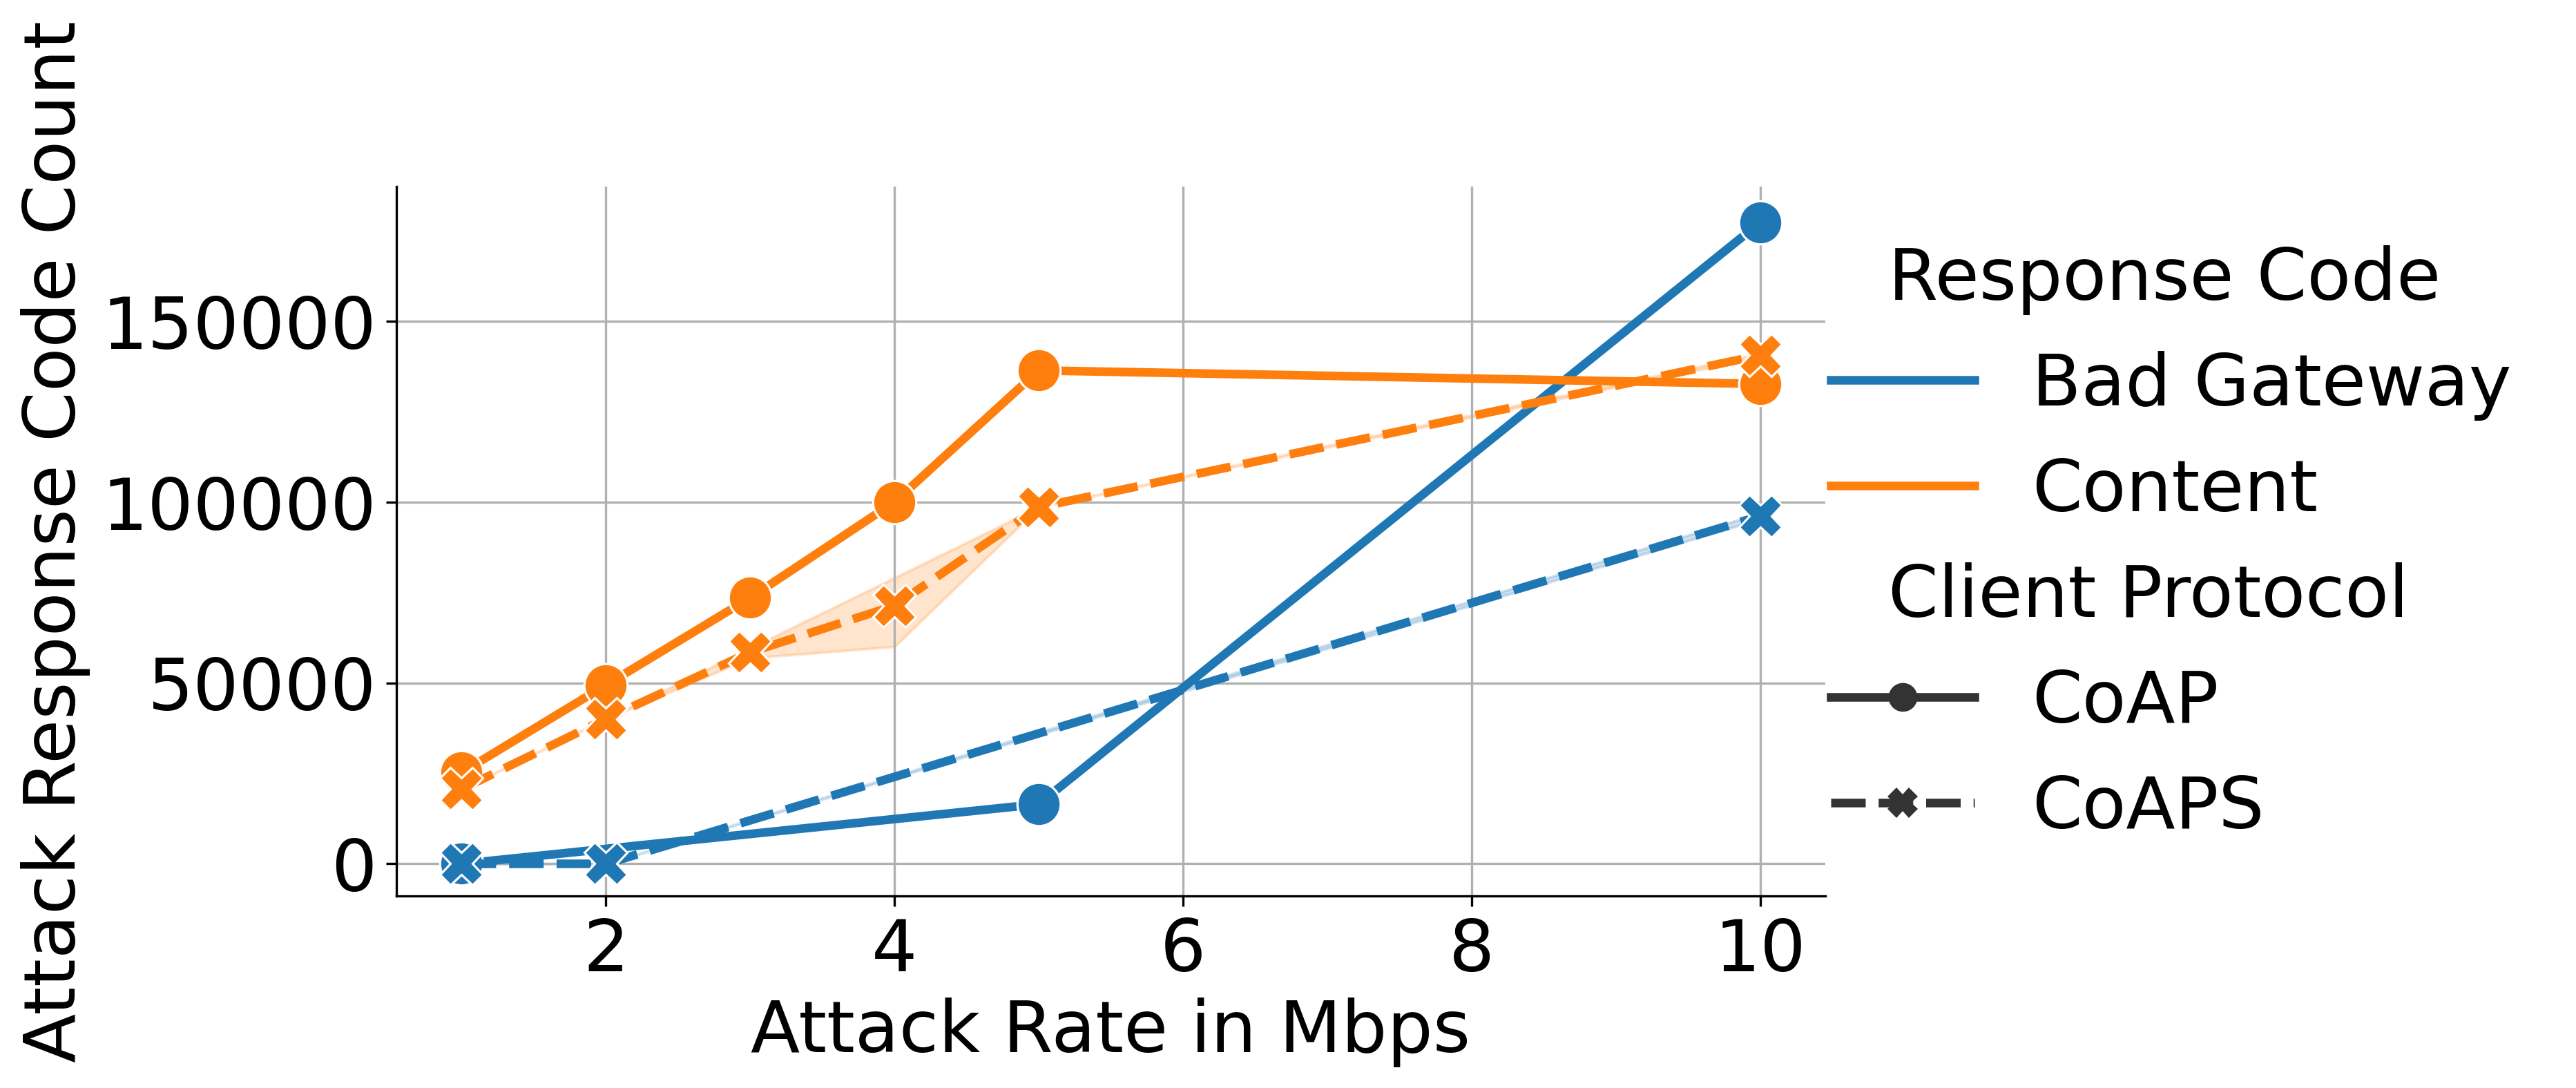

CPU times: user 2.11 s, sys: 149 ms, total: 2.26 s
Wall time: 1.93 s


exp_id  \
0    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_attack_rate_impact_100mbps_8clients_withattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                     ...   
117    thesis_group_attack_rate_impact_5mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
118    thesis_group_attack_rate_impact_5mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
119    thesis_group_attack_rate_impact_5mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
120    thesis_group_attack_rate_impact_5mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
121    thesis_group_attack_rate_impact_5mbps_8clients_withattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial observer_id Response Code  response_code_count  attacker_rate  \
0        1    attacker   Bad Gateway               501646            100   
1        1    attacker       Content               111252            100   
2        2    attacker   Bad Gateway               485093            100   
3        2    attacker       Content               113302            100   
4        3    attacker   Bad Gateway               526792            100   
..     ...         ...           ...                  ...            ...   
117      1    attacker       Content                98503              5   
118      2    attacker       Content                98523              5   
119      3    attacker       Content                98581              5   
120      4    attacker       Content                98521              5   
121      5    attacker       Content                98628              5   

     server_connections  max_keep_alive_requests  num_clients  num_trials  \
0                   256                        0            8           5   
1                   256                        0            8           5   
2                   256                        0            8           5   
3                   256                        0            8           5   
4                   256                        0            8           5   
..                  ...                      ...          ...         ...   
117                 256                        0            8           5   
118                 256                        0            8           5   
119                 256                        0            8           5   
120                 256                        0            8           5   
121                 256                        0            8           5   

     ...  num_proxy_connections  request_timeout  max_retries  \
0    ...                     50                5            2   
1    ...                     50                5            2   
2    ...                     50                5            2   
3    ...                     50                5            2   
4    ...                     50                5            2   
..   ...                    ...              ...          ...   
117  ...                     50                5            2   
118  ...                     50                5            2   
119  ...                     50                5            2   
120  ...                     50                5            2   
121  ...                     50                5  

In [74]:
%%time

df = (
  attacker_message_df
  .replace(value_map_replacement)
  .rename(columns={
    "response_code": "Response Code",
    "run_proxy_with_dtls": "Client Protocol",
  })
)

g = sns.relplot(
  data=df[df["attacker_rate_mbps"] <= 10],
  kind="line",
  x="attacker_rate_mbps",
  y="response_code_count",
  hue="Response Code",
  style="Client Protocol",
  markers=True,
  markersize=15,
  aspect=2,
)

g.set_xlabels("Attack Rate in Mbps")
g.set_ylabels("Attack Response Code Count")

plt.grid(True, axis="both")
plt.show()

df